In [1]:
#%matplotlib widget
%matplotlib inline

import numpy as np
from random import randrange
from matplotlib import pyplot as plt
import pandas as pd
from math import sqrt, erf, exp
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report,auc,r2_score,matthews_corrcoef
from catboost import CatBoostRegressor,CatBoostClassifier
from catboost.utils import get_roc_curve
import shap
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)
from sklearn import preprocessing
from catboost import Pool, cv
from scipy import stats
import copy
from sklearn import feature_selection as fs
from tabulate import tabulate
import tensorflow as tf
from scipy.optimize import curve_fit
from tqdm import tqdm
from numpy.random import RandomState
from scipy import stats

In [2]:
import scipy.stats as stat
from scipy import stats
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

def print_coef(model, columns):
    """ Plot logistic regression model coefficients """ 
    coef = np.abs(pd.DataFrame(np.transpose(model.coef_), index = columns, columns = ['Coefficients']))
    coef = coef.sort_values(by=['Coefficients'], ascending=True)
    plt.figure(figsize = (6,18))
    plt.scatter(y = range(len(coef)), x = coef['Coefficients'])
    plt.yticks(range(len(coef)),coef.index, rotation = 'horizontal')
    plt.xlabel('LR coefficient')
    if present:
        ax = plt.gca()
        ax.patch.set_alpha(0)
    plt.show()
    #return coef
    
def print_coef_std_int(coefs,intercept, columns_feat):
    """ Plot logistic regression model coefficients """ 
    coef = pd.DataFrame(coefs, columns = columns_feat)
    #coef = coef.sort_values(by=['Coefficients'], ascending=True)
    
    quantile = p_values_null_coef(intercept)/100
    if quantile > 0.5:
        p_value_intercept = 1-quantile
    else:
        p_value_intercept = quantile


    p_values_coef = [p_value_intercept]
    for i in range(len(columns_feat)):
        quantile = p_values_null_coef(coefs[:,i])/100
        if quantile > 0.5:
            p_values_coef.append(1-quantile)
        else:
            p_values_coef.append(quantile)
    
    plt.figure(figsize = (6,9))
    plt.errorbar(x = np.append(intercept.mean(),coef.mean().values), y = range(len(columns_feat)+1), xerr = np.append(intercept.std(),coef.std()),ecolor=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color), fmt='none')
    plt.axvline(x=0,color='black',alpha=0.5)
    plt.scatter(x = np.append(intercept.mean(),coef.mean().values), y = range(len(columns_feat)+1),color=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color))
    plt.yticks(range(len(columns_feat)+1),np.append(["AF"],columns_feat), rotation = 'horizontal')
    plt.xlabel('Coefficient')
    if present:
        ax = plt.gca()
        ax.patch.set_alpha(0)
        leg = ax.legend(handles=legend_elements)
        leg.get_frame().set_alpha(0)
        for text in leg.get_texts():
            text.set_color("white")
    else:
        plt.legend(handles=legend_elements)
    plt.show()
    
def print_coef_std(coefs, columns_feat,lim):
    """ Plot logistic regression model coefficients """ 
    coef = pd.DataFrame(coefs, columns = columns_feat)
    #coef = coef.sort_values(by=['Coefficients'], ascending=True)

    p_values_coef = []
    for i in range(len(columns_feat)):
        quantile = p_values_null_coef(coefs[:,i])/100
        if quantile > 0.5:
            p_values_coef.append(1-quantile)
        else:
            p_values_coef.append(quantile)
    
    plt.figure(figsize = (6,9))
    plt.errorbar(x = coef.mean().values, y = range(len(columns_feat)), xerr = [coef.mean().values-coef.quantile(0.05),coef.quantile(0.95)-coef.mean().values],ecolor=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color), fmt='none')
    plt.scatter(x = coef.mean().values, y = range(len(columns_feat)),color=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color))
    plt.yticks(range(len(columns_feat)),columns_feat, rotation = 'horizontal')
    plt.xlabel('Coefficient')
    if present:
        ax = plt.gca()
        ax.patch.set_alpha(0)
        leg = ax.legend(handles=legend_elements)
        leg.get_frame().set_alpha(0)
        for text in leg.get_texts():
            text.set_color("white")
    else:
        plt.legend(handles=legend_elements)
    if lim>0:
        plt.xlim([-lim,lim])

    plt.show()
    
def p_values_lin_reg(model,X,y):
    model.fit(X,y)
    sse = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

    # compute the t-statistic for each feature
    t_test_val = model.coef_ / se
    # find the p-value for each feature
    p_value_lin = np.squeeze(2 * (1 - stat.t.cdf(np.abs(t_test_val), y.shape[0] - X.shape[1])))
    return p_value_lin

def p_values_null_coef(coefficients):
    #inverse of quantile
    return stats.percentileofscore(coefficients,0)

def p_values_arg_coef(coefficients,arg):
    #inverse of quantile
    return stats.percentileofscore(coefficients,arg)

def epsilon_PEHE(y_1,y_0,ITE):
    N = len(y_1)
    
    return 1/N * np.sum(((y_1-y_0)-(ITE))**2)


def epsilon_PEHE(y_1,y_0,ITE):
    N = len(y_1)
    
    return 1/N * np.sum(((y_1-y_0)-(ITE))**2)

def normalized_epsilon_PEHE(y_1,y_0,ITE):
    N = len(y_1)
    
    return 1/N * np.sum(((y_1-y_0)-(ITE))**2) * 1/(np.max(np.append(y_1,y_0))-np.min(np.append(y_1,y_0)))

def sqrt_epsilon_PEHE(y_1,y_0,ITE):
    return np.sqrt(epsilon_PEHE(y_1,y_0,ITE))


def sigmoid(x):
        return 1 / (1 + np.exp(-x))

# Synthetic

In [3]:
runs = 20

for i in range(runs):
    print("RUN: "+str(i)+"/"+str(runs))
    samples = 10000
    n_features = 10
    noise_level = 0.8#0.1

    x=np.random.multivariate_normal(np.zeros(n_features),0.5*(np.random.uniform(-1,1,(n_features,n_features))+np.transpose(np.random.uniform(-1,1,(n_features,n_features)))),(samples))

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    treatment_weights = np.random.uniform(-0.1,0.1,(n_features))
    treatment_noise = np.random.normal(0,noise_level)
    t_cond_x = np.random.binomial(1,sigmoid(np.matmul(x,treatment_weights)+treatment_noise))

    outcome_weights = np.random.uniform(-1,1,(n_features,2))
    outcome_noise = np.random.multivariate_normal(np.zeros(2),[[noise_level,0],[0,noise_level]],(samples))
    Y_cond_x = sigmoid(np.matmul(x,outcome_weights)+outcome_noise)
    Y_cond_x_labels = np.round(Y_cond_x)

    Y_treatment_outcomes = Y_cond_x_labels[:,0]#np.take(Y_cond_x_labels.flatten(),t_cond_x+2*np.arange(0,len(t_cond_x)))

    T0_idx_train,T0_idx_test = train_test_split(np.arange(0,samples)[t_cond_x==0],test_size=0.2)
    T1_idx_train,T1_idx_test = train_test_split(np.arange(0,samples)[t_cond_x==1],test_size=0.2)

    T0_X_train =  x[T0_idx_train]
    T0_X_test =  x[T0_idx_test]
    T0_y_train =  Y_treatment_outcomes[T0_idx_train]
    T0_y_test = Y_treatment_outcomes[T0_idx_test]
    T1_X_train = x[T1_idx_train]
    T1_X_test = x[T1_idx_test]
    T1_y_train = Y_treatment_outcomes[T1_idx_train]
    T1_y_test  = Y_treatment_outcomes[T1_idx_test]

    C_X_train = np.vstack((np.hstack((T0_X_train,np.zeros((len(T0_X_train),1)))),np.hstack((T1_X_train,np.zeros((len(T1_X_train),1))+1))))
    C_X_test_separate = np.vstack((T0_X_test,T1_X_test))
    C_X_test_T0 = np.hstack((C_X_test_separate,np.zeros((len(C_X_test_separate),1))))
    C_X_test_T1 = np.hstack((C_X_test_separate,np.zeros((len(C_X_test_separate),1))+1))
    C_y_train = np.append(T0_y_train,T1_y_train)
    C_y_test = np.append(T0_y_test,T1_y_test)

    T0_class_balance = [T0_y_train.sum()/len(T0_y_train),1-T0_y_train.sum()/len(T0_y_train)]
    T0_CB_model = CatBoostClassifier(verbose=False,iterations=250,class_weights=T0_class_balance)
    T0_CB_model.fit(Pool(T0_X_train,T0_y_train))

    T1_class_balance = [T1_y_train.sum()/len(T1_y_train),1-T1_y_train.sum()/len(T1_y_train)]
    T1_CB_model = CatBoostClassifier(verbose=False,iterations=250,class_weights=T1_class_balance)
    T1_CB_model.fit(Pool(T1_X_train,T1_y_train))

    #C_class_balance = [C_y_train.sum()/len(C_y_train),1-C_y_train.sum()/len(C_y_train)]
    #C_CB_model = CatBoostClassifier(verbose=False,iterations=250,class_weights=C_class_balance)
    #C_CB_model.fit(Pool(C_X_train,C_y_train))

    ITE = T1_CB_model.predict_proba(C_X_test_separate)[:,1]-T0_CB_model.predict_proba(C_X_test_separate)[:,1]
    #combo_ITE = C_CB_model.predict_proba(C_X_test_T1)[:,1]-C_CB_model.predict_proba(C_X_test_T0)[:,1]

    label_ITE = ITE

    X_lin_analysis = pd.DataFrame(C_X_test_separate)

    print("E PEHE = "+str(epsilon_PEHE(Y_cond_x[np.append(T0_idx_test,T1_idx_test),1],Y_cond_x[np.append(T0_idx_test,T1_idx_test),0],label_ITE)))

    from sklearn.linear_model import LinearRegression, LogisticRegression
    intercept = []
    r2s = []
    coefs = np.array([])
    loops = 1000
    for i in range(loops):#(1000):
        if i%250==0:
            print("\r Iteration "+str(i)+"/"+str(loops),end='')
        train_X_LinReg = X_lin_analysis.reset_index(drop=True).sample(int(len(X_lin_analysis)*0.67),random_state=i)
        train_Y_LinReg = label_ITE[train_X_LinReg.index.values]
        Lin_ITE = LinearRegression().fit(train_X_LinReg.values,train_Y_LinReg)
        #r2s.append(r2_score(ITE,Lin_ITE.predict(X_test_ITE_lin_reg.values)))
        intercept.append(Lin_ITE.intercept_)
        if len(coefs)==0:
            coefs = Lin_ITE.coef_
        else:
            coefs = np.vstack([coefs,Lin_ITE.coef_])
    intercept = np.array(intercept)        

    print("")
    quantile = p_values_null_coef(intercept)/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile
    significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  " 
    print(significant_string+"TREATMENT: "+str(np.round(p_value,3)))
    print("Intercept = "+str(np.mean(intercept))+" (+-"+str(np.std(intercept))+")")

    for i in range(len(X_lin_analysis.columns)):
        quantile = p_values_null_coef(coefs[:,i])/100
        if quantile > 0.5:
            p_value = 1-quantile
        else:
            p_value = quantile
        significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  "
        print(significant_string+str(X_lin_analysis.columns[i])+": "+str(np.round(p_value,3)))
    print(100*"=")

RUN: 0/20


covariance is not positive-semidefinite.


E PEHE = 0.2697515685575829
 Iteration 750/1000
-------------------->  TREATMENT: 0.001
Intercept = 0.00501330872611238 (+-0.0018478307637112943)
-------------------->  0: 0.0
-------------------->  1: 0.016
-------------------->  2: 0.0
-------------------->  3: 0.0
-------------------->  4: 0.0
5: 0.278
-------------------->  6: 0.0
-------------------->  7: 0.0
-------------------->  8: 0.019
-------------------->  9: 0.0
RUN: 1/20


covariance is not positive-semidefinite.


E PEHE = 0.21145997584114068
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = -0.013539131313076151 (+-0.002062338101954196)
-------------------->  0: 0.0
-------------------->  1: 0.0
-------------------->  2: 0.016
3: 0.18
-------------------->  4: 0.0
-------------------->  5: 0.0
-------------------->  6: 0.038
-------------------->  7: 0.0
-------------------->  8: 0.001
-------------------->  9: 0.0
RUN: 2/20


covariance is not positive-semidefinite.


E PEHE = 0.22079644288096575
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = 0.022609551112724335 (+-0.0019616242473080117)
0: 0.208
-------------------->  1: 0.0
-------------------->  2: 0.0
3: 0.394
4: 0.298
-------------------->  5: 0.0
-------------------->  6: 0.011
7: 0.116
8: 0.21
9: 0.329
RUN: 3/20


covariance is not positive-semidefinite.


E PEHE = 0.11911166447921052
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = -0.0054562219931340895 (+-0.0018893102331023904)
-------------------->  0: 0.007
1: 0.135
-------------------->  2: 0.0
3: 0.073
-------------------->  4: 0.0
-------------------->  5: 0.0
-------------------->  6: 0.0
-------------------->  7: 0.0
-------------------->  8: 0.0
9: 0.141
RUN: 4/20


covariance is not positive-semidefinite.


E PEHE = 0.2447036857467286
 Iteration 750/1000
TREATMENT: 0.394
Intercept = 0.0005135446833951001 (+-0.0021359508692123217)
-------------------->  0: 0.001
-------------------->  1: 0.0
2: 0.406
-------------------->  3: 0.0
-------------------->  4: 0.0
-------------------->  5: 0.0
-------------------->  6: 0.0
-------------------->  7: 0.0
-------------------->  8: 0.0
-------------------->  9: 0.0
RUN: 5/20


covariance is not positive-semidefinite.


E PEHE = 0.29106915191036264
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = -0.010458453598657465 (+-0.0018647495449249142)
-------------------->  0: 0.001
1: 0.147
-------------------->  2: 0.0
3: 0.152
-------------------->  4: 0.0
-------------------->  5: 0.0
-------------------->  6: 0.005
-------------------->  7: 0.0
8: 0.287
-------------------->  9: 0.013
RUN: 6/20


covariance is not positive-semidefinite.


E PEHE = 0.276486861407492
 Iteration 750/1000
TREATMENT: 0.096
Intercept = 0.0022428551665415585 (+-0.001719860708483167)
0: 0.066
-------------------->  1: 0.016
-------------------->  2: 0.018
-------------------->  3: 0.037
-------------------->  4: 0.032
-------------------->  5: 0.028
-------------------->  6: 0.006
-------------------->  7: 0.035
-------------------->  8: 0.002
9: 0.077
RUN: 7/20


covariance is not positive-semidefinite.


E PEHE = 0.322205129294288
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = 0.01123393932434141 (+-0.0017892787419674357)
-------------------->  0: 0.0
1: 0.095
-------------------->  2: 0.037
3: 0.329
-------------------->  4: 0.0
-------------------->  5: 0.0
6: 0.251
-------------------->  7: 0.0
-------------------->  8: 0.011
9: 0.061
RUN: 8/20


covariance is not positive-semidefinite.


E PEHE = 0.14325416606913133
 Iteration 750/1000
TREATMENT: 0.056
Intercept = -0.003116241663235666 (+-0.0019432155872583289)
0: 0.088
-------------------->  1: 0.0
-------------------->  2: 0.0
-------------------->  3: 0.0
-------------------->  4: 0.0
5: 0.435
6: 0.186
-------------------->  7: 0.0
8: 0.285
9: 0.278
RUN: 9/20


covariance is not positive-semidefinite.


E PEHE = 0.1270571345646948
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = 0.009839762400913546 (+-0.0016996060291469275)
-------------------->  0: 0.0
-------------------->  1: 0.0
-------------------->  2: 0.0
-------------------->  3: 0.0
-------------------->  4: 0.0
5: 0.085
-------------------->  6: 0.035
-------------------->  7: 0.0
-------------------->  8: 0.0
9: 0.165
RUN: 10/20


covariance is not positive-semidefinite.


E PEHE = 0.1411533034787451
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = -0.01582581773886172 (+-0.0020810459073481074)
-------------------->  0: 0.042
1: 0.179
2: 0.344
-------------------->  3: 0.0
4: 0.258
-------------------->  5: 0.001
-------------------->  6: 0.0
-------------------->  7: 0.0
8: 0.358
9: 0.294
RUN: 11/20


covariance is not positive-semidefinite.


E PEHE = 0.13763724915300216
 Iteration 750/1000
-------------------->  TREATMENT: 0.035
Intercept = -0.003223518797998892 (+-0.0018161666133312592)
0: 0.131
-------------------->  1: 0.003
-------------------->  2: 0.006
3: 0.069
-------------------->  4: 0.009
-------------------->  5: 0.013
-------------------->  6: 0.0
-------------------->  7: 0.0
-------------------->  8: 0.0
-------------------->  9: 0.0
RUN: 12/20


covariance is not positive-semidefinite.


E PEHE = 0.24518026114092611
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = 0.008963439914575846 (+-0.0016575809291905312)
0: 0.114
-------------------->  1: 0.0
-------------------->  2: 0.044
-------------------->  3: 0.0
-------------------->  4: 0.0
-------------------->  5: 0.0
6: 0.158
-------------------->  7: 0.0
8: 0.373
9: 0.358
RUN: 13/20


covariance is not positive-semidefinite.


E PEHE = 0.14994389679914202
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = -0.01529259638400391 (+-0.0016651691552166334)
-------------------->  0: 0.0
1: 0.157
-------------------->  2: 0.004
3: 0.071
4: 0.402
-------------------->  5: 0.0
-------------------->  6: 0.003
7: 0.45
8: 0.39
-------------------->  9: 0.0
RUN: 14/20


covariance is not positive-semidefinite.


E PEHE = 0.16059722388608738
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = -0.01091317256091861 (+-0.0018254079511466773)
-------------------->  0: 0.018
-------------------->  1: 0.0
2: 0.352
3: 0.167
-------------------->  4: 0.011
-------------------->  5: 0.0
6: 0.318
-------------------->  7: 0.0
-------------------->  8: 0.001
9: 0.226
RUN: 15/20


covariance is not positive-semidefinite.


E PEHE = 0.22316012250363274
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = 0.01794249483793781 (+-0.0017402437555624317)
-------------------->  0: 0.0
-------------------->  1: 0.0
2: 0.349
-------------------->  3: 0.0
-------------------->  4: 0.012
-------------------->  5: 0.0
6: 0.18
-------------------->  7: 0.0
8: 0.342
-------------------->  9: 0.002
RUN: 16/20


covariance is not positive-semidefinite.


E PEHE = 0.2213392119637699
 Iteration 750/1000
-------------------->  TREATMENT: 0.003
Intercept = 0.006136128034144911 (+-0.002170769337792788)
-------------------->  0: 0.008
-------------------->  1: 0.0
-------------------->  2: 0.0
3: 0.473
-------------------->  4: 0.0
-------------------->  5: 0.003
-------------------->  6: 0.0
-------------------->  7: 0.0
-------------------->  8: 0.0
-------------------->  9: 0.0
RUN: 17/20


covariance is not positive-semidefinite.


E PEHE = 0.2994991896123072
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = -0.019357974125189272 (+-0.001740838317611678)
-------------------->  0: 0.011
-------------------->  1: 0.0
-------------------->  2: 0.047
-------------------->  3: 0.0
-------------------->  4: 0.016
-------------------->  5: 0.014
-------------------->  6: 0.005
-------------------->  7: 0.0
-------------------->  8: 0.0
-------------------->  9: 0.001
RUN: 18/20


covariance is not positive-semidefinite.


E PEHE = 0.23473896429620325
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = -0.0165038676463831 (+-0.0017276926449257377)
-------------------->  0: 0.006
-------------------->  1: 0.0
-------------------->  2: 0.031
-------------------->  3: 0.0
4: 0.178
-------------------->  5: 0.011
-------------------->  6: 0.0
7: 0.143
8: 0.486
-------------------->  9: 0.0
RUN: 19/20


covariance is not positive-semidefinite.


E PEHE = 0.1613839677905953
 Iteration 750/1000
-------------------->  TREATMENT: 0.0
Intercept = 0.011565727623649494 (+-0.001811376014176284)
-------------------->  0: 0.0
-------------------->  1: 0.0
-------------------->  2: 0.0
3: 0.275
4: 0.062
-------------------->  5: 0.036
-------------------->  6: 0.0
-------------------->  7: 0.0
-------------------->  8: 0.016
9: 0.081


In [4]:
print_bool = False
if print_bool:
    print("")
    print("T0 TRAIN")
    print(classification_report(T0_y_train,T0_CB_model.predict(T0_X_train)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T0_CB_model, Pool(data=T0_X_train,label=T0_y_train), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T0_y_train,T0_CB_model.predict(T0_X_train)),4)))
    print(50*"=")


    print("T1 TRAIN")
    print(classification_report(T1_y_train,T1_CB_model.predict(T1_X_train)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T1_CB_model, Pool(data=T1_X_train,label=T1_y_train), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T1_y_train,T1_CB_model.predict(T1_X_train)),4)))
    print(50*"=")

    print("COMBO TRAIN")
    print(classification_report(C_y_train,C_CB_model.predict(C_X_train)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(C_CB_model, Pool(data=C_X_train,label=C_y_train), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(C_y_train,C_CB_model.predict(C_X_train)),4)))
    print(50*"=")

    print("T0 TEST")
    print(classification_report(T0_y_test,T0_CB_model.predict(T0_X_test)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T0_CB_model, Pool(data=T0_X_test,label=T0_y_test), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T0_y_test,T0_CB_model.predict(T0_X_test)),4)))
    print(50*"=")

    print("T1 TEST")
    print(classification_report(T1_y_test,T1_CB_model.predict(T1_X_test)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T1_CB_model, Pool(data=T1_X_test,label=T1_y_test), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T1_y_test,T1_CB_model.predict(T1_X_test)),4)))
    print(50*"=")

    C_X_test_sep_T0 = np.hstack((T0_X_test,np.zeros((len(T0_X_test),1))))
    print("COMBO TEST T0")
    print(classification_report(T0_y_test,C_CB_model.predict(C_X_test_sep_T0)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(C_CB_model, Pool(data=C_X_test_sep_T0,label=T0_y_test), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T0_y_test,C_CB_model.predict(C_X_test_sep_T0)),4)))
    print(50*"=")

    C_X_test_sep_T1 = np.hstack((T1_X_test,np.zeros((len(T1_X_test),1))+1))
    print("COMBO TEST T1")
    print(classification_report(T1_y_test,C_CB_model.predict(C_X_test_sep_T1)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(C_CB_model, Pool(data=C_X_test_sep_T1,label=T1_y_test), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T1_y_test,C_CB_model.predict(C_X_test_sep_T1)),4)))
    print(50*"=")

# TWINS DATASET

## Loading Data and preprocessing

In [93]:
#The covariates data has 46 features
x = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_X_3years_samesex.csv")

#The outcome data contains mortality of the lighter and heavier twin
y = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_Y_3years_samesex.csv")

#The treatment data contains weight in grams of both the twins
t = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_T_3years_samesex.csv")

In [126]:
selection_bias = False

MEAN MORT 1 : 0.1635940873609035
MEAN MORT 0 : 0.18875602059458563
ATE -0.025161933233682127
ITE STD 0.319516317500626
Treatment selection of T1: 0.49750871948181363


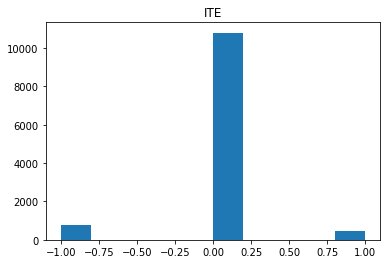

In [127]:
#_0 denotes features specific to the lighter twin and _1 denotes features specific to the heavier twin
lighter_columns = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
        'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
        'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
        'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
        'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
        'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
        'data_year', 'nprevistq', 'dfageq', 'feduc6', #'infant_id_0',
        'dlivord_min', 'dtotord_min', 'bord_0','random_uniform_feature',
        'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']
heavier_columns = [ 'pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
        'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
        'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
        'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
        'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
        'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
        'data_year', 'nprevistq', 'dfageq', 'feduc6',#'infant_id_1', 
        'dlivord_min', 'dtotord_min', 'bord_1','random_uniform_feature',
        'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']

#heavier_columns = ['gestat10', 'nprevistq', 'csex', 'hydra','random_uniform_feature']
#lighter_columns = ['gestat10', 'nprevistq', 'csex', 'hydra','random_uniform_feature']

Exclude_features = ["infant_id_1","infant_id_0",""]

x.columns
x = x[['pldel', 'birattnd', 'brstate',
       'stoccfipb', 'mager8', 'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir',
       'mpre5', 'adequacy', 'orfath', 'frace', 'birmon', 'gestat10', 'csex',
       'anemia', 'cardiac', 'lung', 'diabetes', 'herpes', 'hydra', 'hemo',
       'chyper', 'phyper', 'eclamp', 'incervix', 'pre4000', 'preterm', 'renal',
       'rh', 'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
       'crace', 'data_year', 'nprevistq', 'dfageq', 'feduc6', 'infant_id_0',
       'infant_id_1', 'dlivord_min', 'dtotord_min', 'bord_0', 'bord_1',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']]
dataset = x.copy(deep=True)
dataset["mort_0"]=y.mort_0
dataset["mort_1"]=y.mort_1
dataset["dbirwt_0"]=t.dbirwt_0
dataset["dbirwt_1"]=t.dbirwt_1

#select only if both <=2kg
dataset = dataset[(dataset.dbirwt_0<=2000) & (dataset.dbirwt_1<=2000)]
dataset["lightest_baby"]=0
dataset.loc[dataset.dbirwt_0>dataset.dbirwt_1,"lightest_baby"]=1

print("MEAN MORT 1 : "+str(np.mean(dataset["mort_1"])))
print("MEAN MORT 0 : "+str(np.mean(dataset["mort_0"])))
print("ATE", np.mean(dataset["mort_1"])- np.mean(dataset["mort_0"]))
print("ITE STD", np.std(dataset["mort_1"]- dataset["mort_0"]))
plt.hist(dataset["mort_1"]-dataset["mort_0"])
plt.title("ITE")

if not selection_bias:
    treatment_observation_arr = np.random.randint(0,2,len(dataset))
else:
    #ADD SELECTION BIAS
    noise_level = 0.1
    feat = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
           'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
           'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
           'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
           'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
           'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
           'data_year', 'nprevistq', 'dfageq', 'feduc6',
           'dlivord_min', 'dtotord_min',
           'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']
    n_features = len(feat)
    treatment_weights = np.random.uniform(-0.1,0.1,(n_features))
    treatment_noise = 0#np.random.normal(0,noise_level)
    treatment_observation_arr = np.random.binomial(1,sigmoid(np.matmul(dataset[feat].fillna(0).values,treatment_weights)+treatment_noise))  
    
dataset["treatment"]=treatment_observation_arr
dataset["random_uniform_feature"] = np.random.uniform(-1,1,(len(dataset)))
print("Treatment selection of T1: "+str(sum(treatment_observation_arr)/len(treatment_observation_arr)))

In [128]:
ATEs = []
for i in range(10000):
    if i%100==0:
        print("\r"+str(i),end="")
    sampled_dataset = dataset.sample(int(0.2*len(dataset)),replace=False,random_state=i)
    ATEs.append(np.mean(sampled_dataset["mort_1"])- np.mean(sampled_dataset["mort_0"]))

print("")
print(np.mean(np.array(ATEs)))

9900
-0.025135132890365453


In [129]:
dataset["mort"] = 0
dataset.loc[dataset.treatment==1,"mort"] = dataset[dataset.treatment==1].mort_1
dataset.loc[dataset.treatment==0,"mort"] = dataset[dataset.treatment==0].mort_0

dataset["bord"] = 0
dataset.loc[dataset.treatment==1,"bord"] = dataset[dataset.treatment==1].bord_1
dataset.loc[dataset.treatment==0,"bord"] = dataset[dataset.treatment==0].bord_0

dataset["infant_id"] = 0
dataset.loc[dataset.treatment==1,"infant_id"] = dataset[dataset.treatment==1].infant_id_1
dataset.loc[dataset.treatment==0,"infant_id"] = dataset[dataset.treatment==0].infant_id_0

dataset["dbirwt"] = 0
dataset.loc[dataset.treatment==1,"dbirwt"] = dataset[dataset.treatment==1].dbirwt_1
dataset.loc[dataset.treatment==0,"dbirwt"] = dataset[dataset.treatment==0].dbirwt_0

In [130]:
columns_list = ['pldel', 'birattnd', 'brstate',
       'stoccfipb', 'mager8', 'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir',
       'mpre5', 'adequacy', 'orfath', 'frace', 'birmon', 'gestat10', 'csex',
       'anemia', 'cardiac', 'lung', 'diabetes', 'herpes', 'hydra', 'hemo',
       'chyper', 'phyper', 'eclamp', 'incervix', 'pre4000', 'preterm', 'renal',
       'rh', 'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
       'crace', 'data_year', 'nprevistq', 'dfageq', 'feduc6', 'dlivord_min', 'dtotord_min', 'bord',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']

In [135]:
from causallib.estimation import IPW 

ipw = IPW(CatBoostClassifier(n_estimators=250,verbose=100))
ipw.fit(dataset[columns_list], dataset["treatment"])
potential_outcomes = ipw.estimate_population_outcome(dataset[columns_list], dataset["treatment"], dataset["mort"])
effect = ipw.estimate_effect(potential_outcomes[1], potential_outcomes[0])
effect

Learning rate set to 0.106287
0:	learn: 0.6926568	total: 5.07ms	remaining: 1.26s
100:	learn: 0.6536262	total: 360ms	remaining: 531ms
200:	learn: 0.6105526	total: 727ms	remaining: 177ms
249:	learn: 0.5924484	total: 910ms	remaining: 0us


diff   -0.022039
dtype: float64

In [36]:
import sys
sys.path.append("../../causalteshap/")
from causalteshap import CausalTeShap

In [64]:
ATEs = []
for i in range(10000):
    if i%100==0:
        print("\r"+str(i),end="")
    d_temp = dataset.reset_index(drop=True)

    train_idx, val_idx = train_test_split(
        np.arange(len(d_temp)),
        test_size=0.2,
        random_state=i,
    )

    ATEs.append(np.mean(d_temp.iloc[np.sort(val_idx)].mort_1.values-d_temp.iloc[np.sort(val_idx)].mort_0.values))

print("")
print(np.mean(np.array(ATEs)))

9900
-0.02513615608136156


In [146]:
matched_X, prev_auc,after_auc = causal_selector.propensity_matching(
    dataset[columns_list],
                    dataset.mort.values,dataset["treatment"].values
)

In [147]:
match_dataset = dataset.iloc[matched_X]

np.mean(np.mean(match_dataset[match_dataset["treatment"]==1].mort.values)-np.mean(match_dataset[match_dataset["treatment"]==0].mort.values))

-0.020298317712979963

In [142]:
causal_selector = CausalTeShap(CatBoostClassifier,iterations=10,S_learner=True,power_alpha=0.01,verbose=True,classification=True)

causal_selector.fit(dataset[columns_list],
                    dataset.mort.values,dataset["treatment"].values,propensity_matching=True)

causal_selector.show_all_causality_information()

-0.018480018480018484
-0.018767377201112156
-0.01824059108750864
-0.03014018691588785
-0.02251624883936862
-0.020369936782954817
-0.017400721756553467
-0.02034211742949607
-0.020847810979847115
-0.017923001224815327

Done
Propensity matching was included in fitting - Propensity information: 

Before matching auc 	 | mean (std) = 0.5015 (0.0068)
After matching auc 	 | mean (std) = 0.5015 (0.0056)
T0 amount of class 1 samples 	 |  807 samples = 18.71% of all matched 4314 samples
T1 amount of class 1 samples 	 | 718 samples = 16.66% of all matched 4315 samples

Causality information:
TRAIN: 	 CATE = -0.0322212793955799 	| p-value = 0.0
VAL: 	 CATE = -0.03286403184308402 	| p-value = 0.0
CATE shap stats
----------------------------------------------------------------------
|             |       impact |   p_value |
|:------------|-------------:|----------:|
| T           | -0.250699    |         0 |
| csex        |  0.0202758   |         0 |
| gestat10    |  0.0141057   |         0 |
| dat

## Linear analysis on the ground truth

In [ ]:
add_nan_features = False
lin_anal_loops = 1000
samples = 5000

dataset_linal = dataset.sample(samples)
linal_treatment_observation_arr = np.random.randint(0,2,len(dataset_linal))

X_lin_analysis = dataset_linal[linal_treatment_observation_arr==0][lighter_columns].rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})
X_lin_analysis = X_lin_analysis.append(dataset_linal[linal_treatment_observation_arr==1][heavier_columns].rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'}))
label_ITE = dataset_linal[linal_treatment_observation_arr==0].mort_1.values - dataset_linal[linal_treatment_observation_arr==0].mort_0.values
label_ITE = np.append(label_ITE,dataset_linal[linal_treatment_observation_arr==1].mort_1.values - dataset_linal[linal_treatment_observation_arr==1].mort_0.values)
print(np.mean(label_ITE))

if add_nan_features:
    possible_NaN_features = ['pldel', 'birattnd', 'ormoth',  'meduc6', 'mplbir',
    'mpre5', 'adequacy', 'orfath', 'frace', 
    'anemia', 'cardiac', 'lung', 'diabetes', 'herpes', 'hydra', 'hemo',
    'chyper', 'phyper', 'eclamp', 'incervix', 'pre4000', 'preterm', 'renal',
    'rh', 'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
    'nprevistq', 'dfageq', 'feduc6',  'dlivord_min', 'dtotord_min', 'bord', 
    'mplbir_reg']

    for feat in possible_NaN_features:
        X_lin_analysis[feat+"_NaN"]=0
        X_lin_analysis.loc[X_lin_analysis[feat].isna(),feat+"_NaN"]=1

X_lin_analysis = X_lin_analysis.fillna(X_lin_analysis.mean())

from sklearn.linear_model import LinearRegression, LogisticRegression
intercept = []
r2s = []
coefs = np.array([])
for i in range(lin_anal_loops):#(1000):
    if i%250==0:
        print("\r Iteration "+str(i)+"/"+str(lin_anal_loops),end='')
    train_X_LinReg = X_lin_analysis.reset_index(drop=True).sample(int(len(X_lin_analysis)*0.67),random_state=i)
    train_Y_LinReg = label_ITE[train_X_LinReg.index.values]
    Lin_ITE = LinearRegression().fit(train_X_LinReg.values,train_Y_LinReg)
    #r2s.append(r2_score(ITE,Lin_ITE.predict(X_test_ITE_lin_reg.values)))
    intercept.append(Lin_ITE.intercept_)
    if len(coefs)==0:
        coefs = Lin_ITE.coef_
    else:
        coefs = np.vstack([coefs,Lin_ITE.coef_])
intercept = np.array(intercept)        

print("")
quantile = p_values_null_coef(intercept)/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile
significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  " 
print(significant_string+"TREATMENT: "+str(np.round(p_value,3)))
print("Intercept = "+str(np.mean(intercept))+" (+-"+str(np.std(intercept))+")")

for i in range(len(X_lin_analysis.columns)):
    quantile = p_values_null_coef(coefs[:,i])/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile
    significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  "
    print(significant_string+str(X_lin_analysis.columns[i])+": "+str(np.round(p_value,3)))
print(100*"=")

## Linear Analysis on Catboost ITE estimation (both shared and separate response surfaces)

In [ ]:
add_nan_features = False
verbose_bool = False
do_lin_al = True
combo = False
pehes = []
ITEs = []
runs = 10
lin_anal_loops = 1000

for i in range(runs):
    print("\r run "+str(i)+"/"+str(runs),end="")
    #samples = 10000
    #n_features = 10
    #noise_level = 0.8#0.1

    #treatment_weights = np.random.uniform(-0.1,0.1,(n_features))
    #treatment_noise = np.random.normal(0,noise_level)
    #t_cond_x = np.random.binomial(1,sigmoid(np.matmul(x,treatment_weights)+treatment_noise))

    T0_train_dataset,T0_test_dataset = train_test_split(dataset[treatment_observation_arr==0],test_size=0.2,random_state=i)
    T0_train_dataset,T0_val_dataset = train_test_split(T0_train_dataset,test_size=0.3,random_state=42)

    T1_train_dataset,T1_test_dataset = train_test_split(dataset[treatment_observation_arr==1],test_size=0.2,random_state=i)
    T1_train_dataset,T1_val_dataset = train_test_split(T1_train_dataset,test_size=0.3,random_state=42)

    T0_X_train =  T0_train_dataset[lighter_columns]
    T0_X_val =  T0_val_dataset[lighter_columns]
    T0_X_test =  T0_test_dataset[lighter_columns]
    T0_X_train = T0_X_train.rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})
    T0_X_val = T0_X_val.rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})
    T0_X_test = T0_X_test.rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})

    T0_y_train =  T0_train_dataset["mort_0"]
    T0_y_val =  T0_val_dataset["mort_0"]
    T0_y_test = T0_test_dataset["mort_0"]

    T1_X_train = T1_train_dataset[heavier_columns]
    T1_X_val = T1_val_dataset[heavier_columns]
    T1_X_test = T1_test_dataset[heavier_columns]
    T1_X_train = T1_X_train.rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'})
    T1_X_val = T1_X_val.rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'})
    T1_X_test = T1_X_test.rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'})

    T1_y_train = T1_train_dataset["mort_1"]
    T1_y_val = T1_val_dataset["mort_1"]
    T1_y_test  = T1_test_dataset["mort_1"]
    
    X_test_separate = np.vstack((T0_X_test,T1_X_test))
    
    if combo:
        C_X_train = np.vstack((np.hstack((T0_X_train,np.zeros((len(T0_X_train),1)))),np.hstack((T1_X_train,np.zeros((len(T1_X_train),1))+1))))
        C_X_val = np.vstack((np.hstack((T0_X_val,np.zeros((len(T0_X_val),1)))),np.hstack((T1_X_val,np.zeros((len(T1_X_val),1))+1))))
        C_X_test_T0 = np.hstack((X_test_separate,np.zeros((len(X_test_separate),1))))
        C_X_test_T1 = np.hstack((X_test_separate,np.zeros((len(X_test_separate),1))+1))
        C_y_train = np.append(T0_y_train,T1_y_train)
        C_y_val = np.append(T0_y_val,T1_y_val)
        C_y_test = np.append(T0_y_test,T1_y_test)

    if not combo:
        T0_class_balance = [T0_y_train.sum()/len(T0_y_train),1-T0_y_train.sum()/len(T0_y_train)]
        T0_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=T0_class_balance,use_best_model=True)
        T0_CB_model.fit(Pool(T0_X_train,T0_y_train),eval_set=(T0_X_val,T0_y_val))

        T1_class_balance = [T1_y_train.sum()/len(T1_y_train),1-T1_y_train.sum()/len(T1_y_train)]
        T1_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=T1_class_balance,use_best_model=True)
        T1_CB_model.fit(Pool(T1_X_train,T1_y_train),eval_set=(T1_X_val,T1_y_val))
        
        label_ITE = T1_CB_model.predict_proba(X_test_separate)[:,1]-T0_CB_model.predict_proba(X_test_separate)[:,1]

    else:
        C_class_balance = [C_y_train.sum()/len(C_y_train),1-C_y_train.sum()/len(C_y_train)]
        C_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=C_class_balance,use_best_model=True)
        C_CB_model.fit(Pool(C_X_train,C_y_train),eval_set=(C_X_val,C_y_val))
        
        label_ITE = C_CB_model.predict_proba(C_X_test_T1)[:,1]-C_CB_model.predict_proba(C_X_test_T0)[:,1]

    print("")
    print(np.mean(label_ITE))
    pehes_temp = sqrt_epsilon_PEHE(np.append(T0_test_dataset["mort_1"],T1_test_dataset["mort_1"]),np.append(T0_test_dataset["mort_0"],T1_test_dataset["mort_0"]),label_ITE)
    pehes.append(pehes_temp)
    #print("SQRT(E_PEHE) = "+str(pehes_temp))

    if do_lin_al:
        possible_NaN_features = ['pldel', 'birattnd', 'ormoth',  'meduc6', 'mplbir',
           'mpre5', 'adequacy', 'orfath', 'frace', 
           'anemia', 'cardiac', 'lung', 'diabetes', 'herpes', 'hydra', 'hemo',
           'chyper', 'phyper', 'eclamp', 'incervix', 'pre4000', 'preterm', 'renal',
           'rh', 'uterine', 'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5',
            'nprevistq', 'dfageq', 'feduc6',  'dlivord_min', 'dtotord_min', 'bord', 
            'mplbir_reg']

        X_train_T1_lin_reg = T1_X_train.copy(deep=True)
        X_test_T1_lin_reg = T1_X_test.copy(deep=True)
        X_train_T0_lin_reg = T0_X_train.copy(deep=True)
        X_test_T0_lin_reg = T0_X_test.copy(deep=True)

        if add_nan_features:
            for feat in possible_NaN_features:
                X_train_T1_lin_reg[feat+"_NaN"]=0
                X_train_T1_lin_reg.loc[X_train_T1_lin_reg[feat].isna(),feat+"_NaN"]=1

                X_test_T1_lin_reg[feat+"_NaN"]=0
                X_test_T1_lin_reg.loc[X_test_T1_lin_reg[feat].isna(),feat+"_NaN"]=1

                X_train_T0_lin_reg[feat+"_NaN"]=0
                X_train_T0_lin_reg.loc[X_train_T0_lin_reg[feat].isna(),feat+"_NaN"]=1

                X_test_T0_lin_reg[feat+"_NaN"]=0
                X_test_T0_lin_reg.loc[X_test_T0_lin_reg[feat].isna(),feat+"_NaN"]=1


        X_train_T1_lin_reg = X_train_T1_lin_reg.fillna(0)
        X_test_T1_lin_reg = X_test_T1_lin_reg.fillna(0)
        X_train_T0_lin_reg = X_train_T0_lin_reg.fillna(0)
        X_test_T0_lin_reg = X_test_T0_lin_reg.fillna(0)  

        X_lin_analysis = X_test_T1_lin_reg.append(X_test_T0_lin_reg).sample(len(X_test_T1_lin_reg)+len(X_test_T0_lin_reg),random_state=42)

        #X_lin_analysis = pd.DataFrame(C_X_test_separate)


        from sklearn.linear_model import LinearRegression, LogisticRegression
        intercept = []
        r2s = []
        coefs = np.array([])
        for i in range(lin_anal_loops):#(1000):
            if i%250==0:
                print("\r Iteration "+str(i)+"/"+str(lin_anal_loops),end='')
            train_X_LinReg = X_lin_analysis.reset_index(drop=True).sample(int(len(X_lin_analysis)*0.67),random_state=i)
            train_Y_LinReg = label_ITE[train_X_LinReg.index.values]
            Lin_ITE = LinearRegression().fit(train_X_LinReg.values,train_Y_LinReg)
            #r2s.append(r2_score(ITE,Lin_ITE.predict(X_test_ITE_lin_reg.values)))
            intercept.append(Lin_ITE.intercept_)
            if len(coefs)==0:
                coefs = Lin_ITE.coef_
            else:
                coefs = np.vstack([coefs,Lin_ITE.coef_])
        intercept = np.array(intercept)        

        print("")
        quantile = p_values_null_coef(intercept)/100
        if quantile > 0.5:
            p_value = 1-quantile
        else:
            p_value = quantile
        significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  " 
        print(significant_string+"TREATMENT: "+str(np.round(p_value,3)))
        print("Intercept = "+str(np.mean(intercept))+" (+-"+str(np.std(intercept))+")")

        for i in range(len(X_lin_analysis.columns)):
            quantile = p_values_null_coef(coefs[:,i])/100
            if quantile > 0.5:
                p_value = 1-quantile
            else:
                p_value = quantile
            significant_string = "" if (np.round(p_value,3)>0.05) else 20*"-"+">  "
            print(significant_string+str(X_lin_analysis.columns[i])+": "+str(np.round(p_value,3)))
        print(100*"=")
        
print("")       
print("MEAN SQRT E_PEHE: "+str(np.mean(pehes)))

In [ ]:
print_bool = False
if print_bool:
    print("")
    print("T0 TRAIN")
    print(classification_report(T0_y_train,T0_CB_model.predict(T0_X_train)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T0_CB_model, Pool(data=T0_X_train,label=T0_y_train), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T0_y_train,T0_CB_model.predict(T0_X_train)),4)))
    print(50*"=")

    print("T1 TRAIN")
    print(classification_report(T1_y_train,T1_CB_model.predict(T1_X_train)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T1_CB_model, Pool(data=T1_X_train,label=T1_y_train), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T1_y_train,T1_CB_model.predict(T1_X_train)),4)))
    print(50*"=")

    print("T0 TEST")
    print(classification_report(T0_y_test,T0_CB_model.predict(T0_X_test)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T0_CB_model, Pool(data=T0_X_test,label=T0_y_test), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T0_y_test,T0_CB_model.predict(T0_X_test)),4)))
    print(50*"=")

    print("T1 TEST")
    print(classification_report(T1_y_test,T1_CB_model.predict(T1_X_test)))
    print("\n")
    (fpr, tpr, thresholds) = get_roc_curve(T1_CB_model, Pool(data=T1_X_test,label=T1_y_test), plot=False)
    print("AUC = "+str(np.round(auc(fpr,tpr),4)))
    print("MCC = "+str(np.round(matthews_corrcoef(T1_y_test,T1_CB_model.predict(T1_X_test)),4)))
    print(50*"=")


## ITE Varying Random_state procedure

#### PROPENSITY MATCHING

In [113]:
RS_multiple = 42

feat = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
           'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
           'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
           'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
           'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
           'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
           'data_year', 'nprevistq', 'dfageq', 'feduc6',
           'dlivord_min', 'dtotord_min',
           'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']

train_dat,test_dat,train_y,test_y=train_test_split(dataset,treatment_observation_arr,test_size=0.25,random_state=42)

train_dat = train_dat.reset_index()
#train_dat = dataset.reset_index()
#train_y = treatment_observation_arr

test_dat = test_dat.reset_index()

X_train_or = train_dat[feat].copy(deep=True)

y_train_or = pd.Series(data=train_y)

#if y_train_or.sum()/len(y_train_or)<0.5:
#    y_train = y_train_or[y_train_or==1].append(y_train_or[y_train_or==0].sample(len(y_train_or[y_train_or==1]),random_state=RS_multiple))
#    X_train = X_train_or[y_train_or==1].append(X_train_or[y_train_or==0].sample(len(y_train_or[y_train_or==1]),random_state=RS_multiple))
#else:
#    y_train = y_train_or[y_train_or==0].append(y_train_or[y_train_or==1].sample(len(y_train_or[y_train_or==0]),random_state=RS_multiple))
#    X_train = X_train_or[y_train_or==0].append(X_train_or[y_train_or==1].sample(len(y_train_or[y_train_or==0]),random_state=RS_multiple))
X_train=   X_train_or    
y_train=   y_train_or


In [114]:
X_test_or = test_dat[feat].copy(deep=True)
y_test_or = pd.Series(data=test_y)
y_test = y_test_or
X_test = X_test_or

if y_test_or.sum()/len(y_test_or)<0.5:
    y_test = y_test_or[y_test_or==1].append(y_test_or[y_test_or==0].sample(len(y_test_or[y_test_or==1]),random_state=RS_multiple))
    X_test = X_test_or[y_test_or==1].append(X_test_or[y_test_or==0].sample(len(y_test_or[y_test_or==1]),random_state=RS_multiple))
else:
    y_test = y_test_or[y_test_or==0].append(y_test_or[y_test_or==1].sample(len(y_test_or[y_test_or==0]),random_state=RS_multiple))
    X_test = X_test_or[y_test_or==0].append(X_test_or[y_test_or==1].sample(len(y_test_or[y_test_or==0]),random_state=RS_multiple))

In [115]:
catboost_model = CatBoostClassifier
#catboost_model = CatBoostRegressor
#propensity_class_balance = [y_train.sum()/len(y_train),1-y_train.sum()/len(y_train)]
propensity_class_balance = [y_test.sum()/len(y_test),1-y_test.sum()/len(y_test)]

CB_treat = catboost_model(verbose=False,iterations=500,learning_rate=0.01,class_weights=propensity_class_balance)

#CB_treat.fit(Pool(X_train,y_train))
CB_treat.fit(Pool(X_test,y_test))

print("")
print("TRAIN PATIENTS ")
print(classification_report(y_train,CB_treat.predict(X_train)))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_treat, Pool(data=X_train,label=y_train), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_train,CB_treat.predict(X_train)),4)))
print(50*"=")

print("TEST PATIENTS ")
print(classification_report(y_test,CB_treat.predict(X_test)))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_treat, Pool(data=X_test,label=y_test), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(y_test,CB_treat.predict(X_test)),4)))
print(50*"=")



TRAIN PATIENTS 
              precision    recall  f1-score   support

           0       0.55      0.87      0.67      2610
           1       0.93      0.71      0.81      6421

    accuracy                           0.76      9031
   macro avg       0.74      0.79      0.74      9031
weighted avg       0.82      0.76      0.77      9031



AUC = 0.8703
MCC = 0.5258
TEST PATIENTS 
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       877
           1       0.90      0.80      0.85       877

    accuracy                           0.85      1754
   macro avg       0.86      0.85      0.85      1754
weighted avg       0.86      0.85      0.85      1754



AUC = 0.9444
MCC = 0.711


In [116]:
one_to_one_matching = False
multiple_exact = 1 if one_to_one_matching else 1

In [117]:
from sklearn.neighbors import NearestNeighbors
from scipy.special import logit
causal_label="treatment"

## TRAINING
train_AF_dataset_match = train_dat[feat+["index"]].copy(deep=True).reset_index(drop=True)
train_AF_dataset_match["treatment"]=train_y
train_AF_dataset_match["propensity_score_logit"]=0

y_train_proba = CB_treat.predict_proba(train_AF_dataset_match[feat])
y_train_logit = np.array([logit(xi) for xi in y_train_proba[:,1]])
train_AF_dataset_match.loc[:,"propensity_score_logit"]=y_train_logit

NO_NOR_train_match = train_AF_dataset_match[train_AF_dataset_match[causal_label] == 0].copy(deep=True)
NO_NOR_train_match = NO_NOR_train_match.reset_index(drop=True)
NOR_train_match = train_AF_dataset_match[train_AF_dataset_match[causal_label] == 1].copy(deep=True)
NOR_train_match = NOR_train_match.reset_index(drop=True)

Neighbours = len(NO_NOR_train_match) if one_to_one_matching else multiple_exact

knn = NearestNeighbors(n_neighbors=Neighbours)# , p = 2, radius=np.std(y_train_logit) * 0.25)
knn.fit(NO_NOR_train_match[['propensity_score_logit']].to_numpy())
      

matched_element_arr = np.zeros((len(NOR_train_match),multiple_exact))
j = 0
if one_to_one_matching:
    for row in NOR_train_match.iterrows():
        distance,indexes = knn.kneighbors(np.reshape([row[1].propensity_score_logit],(-1,1)),n_neighbors=Neighbours)

        for idx in indexes[0,:]:
            if idx not in matched_element_arr[:,0]:
                matched_element_arr[j,0] = idx
                break
        j = j+1
        
else:
    for row in NOR_train_match.iterrows():
        distance,indexes = knn.kneighbors(np.reshape([row[1].propensity_score_logit],(-1,1)),n_neighbors=Neighbours)
        for i in range(multiple_exact):
            matched_element_arr[j,i] = indexes[0,i]
        
        j = j+1

if one_to_one_matching:  
    all_matched_data = pd.concat([train_AF_dataset_match[train_AF_dataset_match[causal_label] == 1], NO_NOR_train_match.iloc[matched_element_arr[:,0]]])
else:
    all_matched_data = pd.concat([train_AF_dataset_match[train_AF_dataset_match[causal_label] == 1], NO_NOR_train_match.iloc[matched_element_arr[:,0]]])
    for i in range(multiple_exact-1):
        all_matched_data = pd.concat([all_matched_data, NO_NOR_train_match.iloc[matched_element_arr[:,i]]])
        
all_matched_data = all_matched_data.drop_duplicates("index")

## TEST SET
test_AF_dataset_match = test_dat[feat+["index"]].copy(deep=True).reset_index(drop=True)
test_AF_dataset_match["treatment"]=test_y
test_AF_dataset_match["propensity_score_logit"]=0

y_test_proba = CB_treat.predict_proba(test_AF_dataset_match[feat])
y_test_logit = np.array([logit(xi) for xi in y_test_proba[:,1]])
test_AF_dataset_match.loc[:,"propensity_score_logit"]=y_test_logit

NO_NOR_test_match = test_AF_dataset_match[test_AF_dataset_match[causal_label] == 0].copy(deep=True)
NO_NOR_test_match = NO_NOR_test_match.reset_index(drop=True)
NOR_test_match = test_AF_dataset_match[test_AF_dataset_match[causal_label] == 1].copy(deep=True)
NOR_test_match = NOR_test_match.reset_index(drop=True)

Neighbours = len(NO_NOR_test_match) if one_to_one_matching else multiple_exact

knn = NearestNeighbors(n_neighbors=Neighbours)# , p = 2, radius=np.std(y_test_logit) * 0.25)
knn.fit(NO_NOR_test_match[['propensity_score_logit']].to_numpy())
      

matched_element_arr = np.zeros((len(NOR_test_match),multiple_exact))
j = 0
if one_to_one_matching:
    for row in NOR_test_match.iterrows():
        distance,indexes = knn.kneighbors(np.reshape([row[1].propensity_score_logit],(-1,1)),n_neighbors=Neighbours)

        for idx in indexes[0,:]:
            if idx not in matched_element_arr[:,0]:
                matched_element_arr[j,0] = idx
                break
        j = j+1
        
else:
    for row in NOR_test_match.iterrows():
        distance,indexes = knn.kneighbors(np.reshape([row[1].propensity_score_logit],(-1,1)),n_neighbors=Neighbours)
        for i in range(multiple_exact):
            matched_element_arr[j,i] = indexes[0,i]
        
        j = j+1

if one_to_one_matching:  
    test_all_matched_data = pd.concat([test_AF_dataset_match[test_AF_dataset_match[causal_label] == 1], NO_NOR_test_match.iloc[matched_element_arr[:,0]]])
else:
    test_all_matched_data = pd.concat([test_AF_dataset_match[test_AF_dataset_match[causal_label] == 1], NO_NOR_test_match.iloc[matched_element_arr[:,0]]])
    for i in range(multiple_exact-1):
        test_all_matched_data = pd.concat([test_all_matched_data, NO_NOR_test_match.iloc[matched_element_arr[:,i]]])
        
test_all_matched_data = test_all_matched_data.drop_duplicates("index")



In [118]:
print("")
print("TRAIN BALANCE")
print(classification_report(all_matched_data[causal_label],CB_treat.predict(all_matched_data[feat])))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_treat, Pool(data=all_matched_data[feat],label=all_matched_data[causal_label]), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(all_matched_data[causal_label],CB_treat.predict(all_matched_data[feat])),4)))
print(50*"=")

print("")
print("TEST BALANCE")
print(classification_report(test_all_matched_data[causal_label],CB_treat.predict(test_all_matched_data[feat])))
print("\n")
(fpr, tpr, thresholds) = get_roc_curve(CB_treat, Pool(data=test_all_matched_data[feat],label=test_all_matched_data[causal_label]), plot=False)
print("AUC = "+str(np.round(auc(fpr,tpr),4)))
print("MCC = "+str(np.round(matthews_corrcoef(test_all_matched_data[causal_label],CB_treat.predict(test_all_matched_data[feat])),4)))
print(50*"=")


TRAIN BALANCE
              precision    recall  f1-score   support

           0       0.34      0.74      0.47      1285
           1       0.93      0.71      0.81      6421

    accuracy                           0.72      7706
   macro avg       0.64      0.73      0.64      7706
weighted avg       0.83      0.72      0.75      7706



AUC = 0.7962
MCC = 0.3533

TEST BALANCE
              precision    recall  f1-score   support

           0       0.34      0.77      0.47       341
           1       0.95      0.76      0.84      2134

    accuracy                           0.76      2475
   macro avg       0.65      0.77      0.66      2475
weighted avg       0.87      0.76      0.79      2475



AUC = 0.8522
MCC = 0.3926


In [119]:
dataset_temp = dataset[dataset.index.isin(all_matched_data.index)].copy(deep=True)

In [120]:
dataset = dataset_temp
treatment_observation_arr = dataset_temp.treatment

#### Procedure

In [45]:
add_nan_features = False
verbose_bool = False
selection_bias = False
shap_prognost_predict = True
combo = True #if set to True, we use a S-learner, if set to false we use T-learner
pehes = []
mean_ITEs = []
std_ITEs = []
train_pehes = []
train_std_ITEs = []
train_mean_ITEs = []
bootstrap_iterations = 500#0
test_test_size = 0.2
val_test_size = 0.3
shap_difs = np.array([])
T0_shaps = np.array([])
T0_shap_values_ar = np.array([])
T1_shaps  = np.array([])
T1_shap_values_ar = np.array([])
T1_X_shap_ar = np.array([])
T0_X_shap_ar = np.array([])

for i in tqdm(range(bootstrap_iterations),ascii==True):
    #print("\rRun "+str(i+1)+"/"+str(bootstrap_iterations),end="")
    
    treatment_observation_arr = np.array([0]) 
    while(np.mean(treatment_observation_arr)<0.2 or np.mean(treatment_observation_arr)>0.8): 
        if not selection_bias:
            treatment_observation_arr = np.random.randint(0,2,len(dataset))
        else:
            #ADD SELECTION BIAS
            noise_level = 0.1
            feat = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
                   'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
                   'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
                   'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
                   'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
                   'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
                   'data_year', 'nprevistq', 'dfageq', 'feduc6',
                   'dlivord_min', 'dtotord_min',
                   'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']
            #feat=['gestat10', 'nprevistq', 'csex', 'hydra']
            n_features = len(feat)
            treatment_weights = np.random.uniform(-0.1,0.1,(n_features))
            treatment_noise = np.random.normal(0,noise_level)
            treatment_observation_arr = np.random.binomial(1,sigmoid(np.matmul(dataset[feat].fillna(0).values,treatment_weights)+treatment_noise))  

    T0_train_dataset,T0_test_dataset = train_test_split(dataset[treatment_observation_arr==0],test_size=test_test_size,random_state=i)
    T0_train_dataset,T0_val_dataset = train_test_split(T0_train_dataset,test_size=val_test_size,random_state=i)

    T1_train_dataset,T1_test_dataset = train_test_split(dataset[treatment_observation_arr==1],test_size=test_test_size,random_state=i)
    T1_train_dataset,T1_val_dataset = train_test_split(T1_train_dataset,test_size=val_test_size,random_state=i)

    T0_X_train =  T0_train_dataset[lighter_columns]
    T0_X_val =  T0_val_dataset[lighter_columns]
    T0_X_test =  T0_test_dataset[lighter_columns]
    T0_X_train = T0_X_train.rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})
    T0_X_val = T0_X_val.rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})
    T0_X_test = T0_X_test.rename(columns={'infant_id_0':'infant_id',  'bord_0':'bord'})

    T0_y_train =  T0_train_dataset["mort_0"]
    T0_y_val =  T0_val_dataset["mort_0"]
    T0_y_test = T0_test_dataset["mort_0"]

    T1_X_train = T1_train_dataset[heavier_columns]
    T1_X_val = T1_val_dataset[heavier_columns]
    T1_X_test = T1_test_dataset[heavier_columns]
    T1_X_train = T1_X_train.rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'})
    T1_X_val = T1_X_val.rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'})
    T1_X_test = T1_X_test.rename(columns={'infant_id_1':'infant_id',  'bord_1':'bord'})

    T1_y_train = T1_train_dataset["mort_1"]
    T1_y_val = T1_val_dataset["mort_1"]
    T1_y_test  = T1_test_dataset["mort_1"]
    
    X_test_separate = pd.DataFrame(data=np.vstack((T0_X_test,T1_X_test)),columns=T0_X_test.columns)
    X_train_separate = pd.DataFrame(data=np.vstack((T0_X_train,T1_X_train)),columns=T0_X_train.columns) 
    
    if combo:
        C_X_train = pd.DataFrame(data=np.vstack((np.hstack((T0_X_train,np.zeros((len(T0_X_train),1)))),np.hstack((T1_X_train,np.zeros((len(T1_X_train),1))+1)))),columns=np.append(T0_X_train.columns.values,"treatment"))
        C_X_val = pd.DataFrame(data=np.vstack((np.hstack((T0_X_val,np.zeros((len(T0_X_val),1)))),np.hstack((T1_X_val,np.zeros((len(T1_X_val),1))+1)))),columns=np.append(T0_X_val.columns.values,"treatment"))
        C_X_test_T0 = pd.DataFrame(data=np.hstack((X_test_separate,np.zeros((len(X_test_separate),1)))),columns=np.append(X_test_separate.columns.values,"treatment"))
        C_X_test_T1 = pd.DataFrame(data=np.hstack((X_test_separate,np.zeros((len(X_test_separate),1))+1)),columns=np.append(X_test_separate.columns.values,"treatment"))
        C_X_train_T0 = pd.DataFrame(data=np.hstack((X_train_separate,np.zeros((len(X_train_separate),1)))),columns=np.append(X_train_separate.columns.values,"treatment"))
        C_X_train_T1 = pd.DataFrame(data=np.hstack((X_train_separate,np.zeros((len(X_train_separate),1))+1)),columns=np.append(X_train_separate.columns.values,"treatment"))
        C_y_train = np.append(T0_y_train,T1_y_train)
        C_y_val = np.append(T0_y_val,T1_y_val)
        C_y_test = np.append(T0_y_test,T1_y_test)

    if not combo:
        T0_class_balance = [T0_y_train.sum()/len(T0_y_train),1-T0_y_train.sum()/len(T0_y_train)]
        T0_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=T0_class_balance,use_best_model=True)
        T0_CB_model.fit(Pool(T0_X_train,T0_y_train),eval_set=(T0_X_val,T0_y_val))

        T1_class_balance = [T1_y_train.sum()/len(T1_y_train),1-T1_y_train.sum()/len(T1_y_train)]
        T1_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=T1_class_balance,use_best_model=True)
        T1_CB_model.fit(Pool(T1_X_train,T1_y_train),eval_set=(T1_X_val,T1_y_val))
        
        label_ITE = T1_CB_model.predict_proba(X_test_separate)[:,1]-T0_CB_model.predict_proba(X_test_separate)[:,1]
        train_label_ITE = T1_CB_model.predict_proba(X_train_separate)[:,1]-T0_CB_model.predict_proba(X_train_separate)[:,1]
        
        T1_explainer = shap.TreeExplainer(T1_CB_model)
        T1_shap_values = np.abs(T1_explainer.shap_values(X_test_separate))
        T0_explainer = shap.TreeExplainer(T0_CB_model)
        T0_shap_values = np.abs(T0_explainer.shap_values(X_test_separate))
        shap_diff_ar = np.mean(T1_shap_values-T0_shap_values,axis=0)
        if len(shap_difs)>0:
            shap_difs = np.vstack([shap_difs,shap_diff_ar])
            T0_shaps = np.vstack([T0_shaps,np.mean(T0_shap_values,axis=0)])
            T1_shaps = np.vstack([T1_shaps,np.mean(T1_shap_values,axis=0)])
        else:
            shap_difs = shap_diff_ar
            T0_shaps = np.mean(T0_shap_values,axis=0)
            T1_shaps = np.mean(T1_shap_values,axis=0)

    else:
        C_class_balance = [C_y_train.sum()/len(C_y_train),1-C_y_train.sum()/len(C_y_train)]
        C_CB_model = CatBoostClassifier(verbose=verbose_bool,iterations=100,class_weights=C_class_balance,use_best_model=True)
        C_CB_model.fit(Pool(C_X_train,C_y_train),eval_set=(C_X_val,C_y_val))
        
        label_ITE = C_CB_model.predict_proba(C_X_test_T1)[:,1]-C_CB_model.predict_proba(C_X_test_T0)[:,1]
        train_label_ITE = C_CB_model.predict_proba(C_X_train_T1)[:,1]-C_CB_model.predict_proba(C_X_train_T0)[:,1]

        C_explainer = shap.TreeExplainer(C_CB_model)
        T1_shap_values = C_explainer.shap_values(C_X_test_T1)
        T0_shap_values = C_explainer.shap_values(C_X_test_T0)
        
        if len(T0_shap_values_ar)>0:
            T0_shap_values_ar = np.vstack([T0_shap_values_ar,T0_shap_values])
            T1_shap_values_ar = np.vstack([T1_shap_values_ar,T1_shap_values])
            T1_X_shap_ar = np.vstack([T1_X_shap_ar,C_X_test_T1])
            T0_X_shap_ar = np.vstack([T0_X_shap_ar,C_X_test_T0])
        else:
            T0_shap_values_ar = T0_shap_values
            T1_shap_values_ar = T1_shap_values
            T1_X_shap_ar = C_X_test_T1
            T0_X_shap_ar = C_X_test_T0
        
        T1_shap_values = np.abs(T1_shap_values)
        T0_shap_values = np.abs(T0_shap_values)
        
        shap_diff_ar = np.mean(T1_shap_values-T0_shap_values,axis=0)
        if len(shap_difs)>0:
            shap_difs = np.vstack([shap_difs,shap_diff_ar])
            T0_shaps = np.vstack([T0_shaps,np.mean(T0_shap_values,axis=0)])
            T1_shaps = np.vstack([T1_shaps,np.mean(T1_shap_values,axis=0)])
        else:
            shap_difs = shap_diff_ar
            T0_shaps = np.mean(T0_shap_values,axis=0)
            T1_shaps = np.mean(T1_shap_values,axis=0)
            


    #print("")
    #print(np.mean(label_ITE))
    mean_ITEs.append(np.mean(label_ITE))
    std_ITEs.append(np.std(label_ITE))
    train_mean_ITEs.append(np.mean(train_label_ITE))
    train_std_ITEs.append(np.std(train_label_ITE))
    pehes_temp = sqrt_epsilon_PEHE(np.append(T0_test_dataset["mort_1"],T1_test_dataset["mort_1"]),np.append(T0_test_dataset["mort_0"],T1_test_dataset["mort_0"]),label_ITE)
    train_pehes_temp = sqrt_epsilon_PEHE(np.append(T0_train_dataset["mort_1"],T1_train_dataset["mort_1"]),np.append(T0_train_dataset["mort_0"],T1_train_dataset["mort_0"]),train_label_ITE)
    pehes.append(pehes_temp)
    train_pehes.append(train_pehes_temp)
    #print("SQRT(E_PEHE) = "+str(pehes_temp))

#it does not matter which column array I pick, they all have the same
if combo:
    shap_difs_pd = pd.DataFrame(data=shap_difs,columns=np.append(T0_X_train.columns.values,"treatment"))
    T0_shaps_pd = pd.DataFrame(data=T0_shaps,columns=np.append(T0_X_train.columns.values,"treatment"))
    T1_shaps_pd = pd.DataFrame(data=T1_shaps,columns=np.append(T0_X_train.columns.values,"treatment"))
else:
    shap_difs_pd = pd.DataFrame(data=shap_difs,columns=T0_X_train.columns) 
    T0_shaps_pd = pd.DataFrame(data=T0_shaps,columns=T0_X_train.columns) 
    T1_shaps_pd = pd.DataFrame(data=T1_shaps,columns=T0_X_train.columns) 

########################################################################################################################################################   
## SHAP VALUE DIFFERENCE ANALYSIS
p_values = []
for i in range(len(shap_difs_pd.columns)):
    quantile = p_values_null_coef(np.array(shap_difs_pd.values[:,i]))/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile
    p_values.append(p_value)
    
processed_shap_diff_pd = pd.DataFrame(data=np.hstack([np.reshape(shap_difs_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_absolute_shap","p_value"],index=shap_difs_pd.mean().index)
processed_shap_diff_pd = processed_shap_diff_pd.reindex(processed_shap_diff_pd.mean_shap.abs().sort_values(ascending=False).index)

## SHAP VALUE DIFFERENCE ANALYSIS
p_values = []
for i in range(len(T0_shaps_pd.columns)):
    if shap_prognost_predict:
        mean_random_uniform = T0_shaps_pd["random_uniform_feature"].values.mean()
        quantile = p_values_arg_coef(np.array(T0_shaps_pd.values[:,i]),mean_random_uniform)/100
        p_value = quantile
    else:
        quantile = p_values_null_coef(np.array(T0_shaps_pd.values[:,i]))/100
        if quantile > 0.5:
            p_value = 1-quantile
        else:
            p_value = quantile
    p_values.append(p_value)
    
processed_T0_shaps_pd = pd.DataFrame(data=np.hstack([np.reshape(T0_shaps_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_absolute_shap","p_value"],index=T0_shaps_pd.mean().index)
processed_T0_shaps_pd = processed_T0_shaps_pd.reindex(processed_T0_shaps_pd.mean_shap.abs().sort_values(ascending=False).index)

## SHAP VALUE DIFFERENCE ANALYSIS
p_values = []
for i in range(len(T1_shaps_pd.columns)):
    if shap_prognost_predict:
        mean_random_uniform = T1_shaps_pd["random_uniform_feature"].values.mean()
        quantile = p_values_arg_coef(np.array(T1_shaps_pd.values[:,i]),mean_random_uniform)/100
        p_value = quantile
    else:
        quantile = p_values_null_coef(np.array(T1_shaps_pd.values[:,i]))/100
        if quantile > 0.5:
            p_value = 1-quantile
        else:
            p_value = quantile
    p_values.append(p_value)
    
processed_T1_shaps_pd = pd.DataFrame(data=np.hstack([np.reshape(T1_shaps_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_absolute_shap","p_value"],index=T1_shaps_pd.mean().index)
processed_T1_shaps_pd = processed_T1_shaps_pd.reindex(processed_T1_shaps_pd.mean_shap.abs().sort_values(ascending=False).index)
########################################################################################################################################################   

## RESULT PRINTING
print("")       
print("TRAINING SET")
quantile = p_values_null_coef(np.array(train_mean_ITEs))/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile

print(tabulate([[np.round(np.mean(train_pehes),5),str(np.round(np.mean(train_mean_ITEs),5))+" (+-"+str(np.round(np.std(train_mean_ITEs),5))+")",str(np.round(np.mean(train_std_ITEs),5))+" (+-"+str(np.round(np.std(train_std_ITEs),5))+")",p_value]], ["SQRT E PEHE","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))
    
print("")       
print("TEST SET")
quantile = p_values_null_coef(np.array(mean_ITEs))/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile

print(tabulate([[np.round(np.mean(pehes),5),str(np.round(np.mean(mean_ITEs),5))+" (+-"+str(np.round(np.std(mean_ITEs),5))+")",str(np.round(np.mean(std_ITEs),5))+" (+-"+str(np.round(np.std(std_ITEs),5))+")",p_value]], ["SQRT E PEHE","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [09:07<00:00,  1.09s/it]


TRAINING SET
+---------------+----------------------+---------------------+---------------------+
|   SQRT E PEHE | ATE (std)            | STD ITE (std)       |   p-Value Treatment |
+===============+======================+=====================+=====================+
|        0.3188 | -0.03257 (+-0.01205) | 0.02998 (+-0.00715) |                   0 |
+---------------+----------------------+---------------------+---------------------+

TEST SET
+---------------+----------------------+---------------------+---------------------+
|   SQRT E PEHE | ATE (std)            | STD ITE (std)       |   p-Value Treatment |
+===============+======================+=====================+=====================+
|       0.32095 | -0.03258 (+-0.01209) | 0.02972 (+-0.00704) |                   0 |
+---------------+----------------------+---------------------+---------------------+


In [52]:
processed_T1_shaps_pd[processed_T1_shaps_pd.p_value<0.05]

,mean_shap,p_value
gestat10,1.313800,0.000
nprevistq,0.212441,0.000
csex,0.121755,0.004
treatment,0.102638,0.014
hydra,0.074052,0.002
data_year,0.059552,0.048


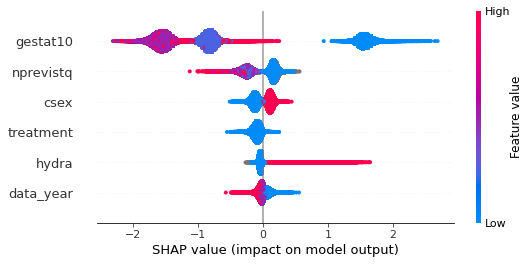

In [53]:
idx = np.where(np.isin(C_X_test_T1.columns.values,processed_T1_shaps_pd[processed_T1_shaps_pd.p_value<0.05].index.values))
shap.summary_plot(T1_shap_values_ar[:,list(idx[0])],pd.DataFrame(data=T1_X_shap_ar[:,list(idx[0])],columns=C_X_test_T1.columns[idx]))

In [54]:
processed_T0_shaps_pd[processed_T0_shaps_pd.p_value<0.05]

,mean_shap,p_value
gestat10,1.274192,0.000
nprevistq,0.204924,0.000
csex,0.118234,0.006
treatment,0.091912,0.024
hydra,0.074803,0.002


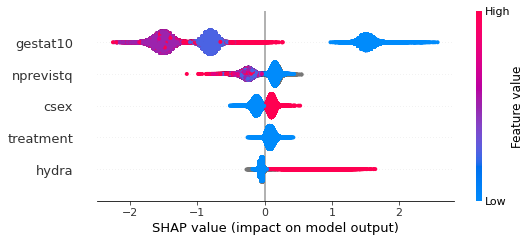

In [55]:
idx = np.where(np.isin(C_X_test_T0.columns.values,processed_T0_shaps_pd[processed_T0_shaps_pd.p_value<0.05].index.values))
shap.summary_plot(T0_shap_values_ar[:,list(idx[0])],pd.DataFrame(data=T0_X_shap_ar[:,list(idx[0])],columns=C_X_test_T0.columns[idx]))

In [50]:
processed_shap_diff_pd[processed_shap_diff_pd.p_value<0.05]

,mean_shap,p_value
gestat10,0.039608,0.008
treatment,0.010725,0.000


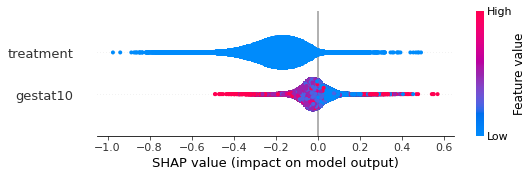

In [51]:
idx = np.where(np.isin(C_X_test_T0.columns.values,processed_shap_diff_pd[processed_shap_diff_pd.p_value<0.05].index.values))
shap.summary_plot(T1_shap_values_ar[:,list(idx[0])]-T0_shap_values_ar[:,list(idx[0])],pd.DataFrame(data=T0_X_shap_ar[:,list(idx[0])],columns=C_X_test_T0.columns[idx]))

- T1 - T0 
- Mortality = 1, survival = 0  
- -> negative: T0_mortality > T1_mortality 
- high shap value (>0) -> more chance for mortality 
- lower shap value (<0) -> less chance for mortality 
- positive shap difference -> feature influences predicton adding more mortality in T1 compared to T0 
- negative shap difference -> feature influences predicton adding more mortality in T0 compared to T1

# IHDP DATASET

In [210]:
dataset= pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216,1,0,1,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,1.295216,0,0,0,1,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556,0,0,0,1,0,0,0,2,0,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787,0,0,0,0,0,1,1,2,0,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,-0.360940,1,0,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0,0,0


In [211]:
col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]

for i in range(1,26):
    col.append("x"+str(i))
dataset.columns = col

dataset["y_1_outcome"]=0
dataset["y_0_outcome"]=0
dataset.loc[dataset.treatment==1,"y_1_outcome"]=dataset[dataset.treatment==1].y_factual
dataset.loc[dataset.treatment==1,"y_0_outcome"]=dataset[dataset.treatment==1].y_cfactual

dataset.loc[dataset.treatment==0,"y_0_outcome"]=dataset[dataset.treatment==0].y_factual
dataset.loc[dataset.treatment==0,"y_1_outcome"]=dataset[dataset.treatment==0].y_cfactual

dataset.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,y_1_outcome,y_0_outcome
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216,1,0,1,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,5.599916,4.318780
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,1.295216,0,0,0,1,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,7.856495,6.875856
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556,0,0,0,1,0,0,0,2,0,1,0,1,1,0,0,0,0,0,0,6.633952,2.996273
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787,0,0,0,0,0,1,1,2,0,1,0,1,1,0,0,0,0,0,0,5.697239,1.366206
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,-0.360940,1,0,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0,0,0,6.202582,1.963538


In [212]:
feature_cols = ['x1',
             'x2',
             'x3',
             'x4',
             'x5',
             'x6',
             'x7',
             'x8',
             'x9',
             'x10',
             'x11',
             'x12',
             'x13',
             'x14',
             'x15',
             'x16',
             'x17',
             'x18',
             'x19',
             'x20',
             'x21',
             'x22',
             'x23',
             'x24',
             'x25']

#fixing some outliers 
for col in feature_cols:
    dataset.loc[(dataset[col].values>dataset[~dataset[col].isna()][col].quantile(0.99))
                            |(dataset[col].values<dataset[~dataset[col].isna()][col].quantile(0.01)),col]=np.NaN
    
dataset = dataset.fillna(dataset.mean())

MEAN FACTUAL : 3.1595375238575967
MEAN COUNTERFACTUAL : 5.69610655030994
ATE 4.0296612252169
ITE STD 1.5997122212409884
Treatment selection of T1: 0.18607764390896922


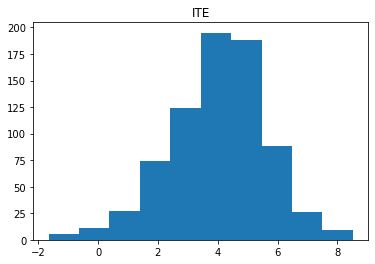

In [213]:
print("MEAN FACTUAL : "+str(np.mean(dataset["y_factual"])))
print("MEAN COUNTERFACTUAL : "+str(np.mean(dataset["y_cfactual"])))
print("ATE", np.mean(dataset["y_1_outcome"])- np.mean(dataset["y_0_outcome"]))
print("ITE STD", np.std(dataset["y_1_outcome"]- dataset["y_0_outcome"]))
plt.hist(dataset["y_1_outcome"]-dataset["y_0_outcome"])
plt.title("ITE")

if not selection_bias:
    #treatment_observation_arr = dataset["treatment"]#np.random.randint(0,2,len(dataset))
    treatment_observation_arr = np.random.randint(0,2,len(dataset))
else:
    #ADD SELECTION BIAS
    #noise_level = 0.1
    #feat = feature_cols
    #n_features = len(feat)
    #treatment_weights = np.random.uniform(-0.1,0.1,(n_features))
    #treatment_noise = np.random.normal(0,noise_level)
    treatment_observation_arr = dataset["treatment"]#np.random.binomial(1,sigmoid(np.matmul(dataset[feat].fillna(0).values,treatment_weights)+treatment_noise))  
    
dataset["treatment"]=treatment_observation_arr
print("Treatment selection of T1: "+str(sum(treatment_observation_arr)/len(treatment_observation_arr)))

In [214]:
add_nan_features = False
verbose_bool = False
combo = True
pehes = []
mean_ITEs = []
std_ITEs = []
train_pehes = []
train_std_ITEs = []
train_mean_ITEs = []
bootstrap_iterations = 100#00
test_test_size = 0.2
val_test_size = 0.2
shap_difs = np.array([])

for i in tqdm(range(bootstrap_iterations),ascii==True):
    #print("\rRun "+str(i+1)+"/"+str(bootstrap_iterations),end="")

    T0_train_dataset,T0_test_dataset = train_test_split(dataset[dataset.treatment==0],test_size=test_test_size,random_state=i)
    T0_train_dataset,T0_val_dataset = train_test_split(T0_train_dataset,test_size=val_test_size,random_state=i)

    T1_train_dataset,T1_test_dataset = train_test_split(dataset[dataset.treatment==1],test_size=test_test_size,random_state=i)
    T1_train_dataset,T1_val_dataset = train_test_split(T1_train_dataset,test_size=val_test_size,random_state=i)

    T0_X_train =  T0_train_dataset[feature_cols]
    T0_X_val =  T0_val_dataset[feature_cols]
    T0_X_test =  T0_test_dataset[feature_cols]

    T0_y_train =  T0_train_dataset["y_0_outcome"]
    T0_y_val =  T0_val_dataset["y_0_outcome"]
    T0_y_test = T0_test_dataset["y_0_outcome"]

    T1_X_train = T1_train_dataset[feature_cols]
    T1_X_val = T1_val_dataset[feature_cols]
    T1_X_test = T1_test_dataset[feature_cols]
    
    T1_y_train = T1_train_dataset["y_1_outcome"]
    T1_y_val = T1_val_dataset["y_1_outcome"]
    T1_y_test  = T1_test_dataset["y_1_outcome"]
    
    X_test_separate = pd.DataFrame(data=np.vstack((T0_X_test,T1_X_test)),columns=T0_X_test.columns)
    X_train_separate = pd.DataFrame(data=np.vstack((T0_X_train,T1_X_train)),columns=T0_X_train.columns) 
    
    if combo:
        C_X_train = pd.DataFrame(data=np.vstack((np.hstack((T0_X_train,np.zeros((len(T0_X_train),1)))),np.hstack((T1_X_train,np.zeros((len(T1_X_train),1))+1)))),columns=np.append(T0_X_train.columns.values,"treatment"))
        C_X_val = pd.DataFrame(data=np.vstack((np.hstack((T0_X_val,np.zeros((len(T0_X_val),1)))),np.hstack((T1_X_val,np.zeros((len(T1_X_val),1))+1)))),columns=np.append(T0_X_val.columns.values,"treatment"))
        C_X_test_T0 = pd.DataFrame(data=np.hstack((X_test_separate,np.zeros((len(X_test_separate),1)))),columns=np.append(X_test_separate.columns.values,"treatment"))
        C_X_test_T1 = pd.DataFrame(data=np.hstack((X_test_separate,np.zeros((len(X_test_separate),1))+1)),columns=np.append(X_test_separate.columns.values,"treatment"))
        C_X_train_T0 = pd.DataFrame(data=np.hstack((X_train_separate,np.zeros((len(X_train_separate),1)))),columns=np.append(X_train_separate.columns.values,"treatment"))
        C_X_train_T1 = pd.DataFrame(data=np.hstack((X_train_separate,np.zeros((len(X_train_separate),1))+1)),columns=np.append(X_train_separate.columns.values,"treatment"))
        C_y_train = np.append(T0_y_train,T1_y_train)
        C_y_val = np.append(T0_y_val,T1_y_val)
        C_y_test = np.append(T0_y_test,T1_y_test)

    if not combo:
        T0_CB_model = CatBoostRegressor(verbose=verbose_bool,iterations=100,use_best_model=True)
        T0_CB_model.fit(Pool(T0_X_train,T0_y_train),eval_set=(T0_X_val,T0_y_val))

        T1_class_balance = [T1_y_train.sum()/len(T1_y_train),1-T1_y_train.sum()/len(T1_y_train)]
        T1_CB_model = CatBoostRegressor(verbose=verbose_bool,iterations=100,use_best_model=True)
        T1_CB_model.fit(Pool(T1_X_train,T1_y_train),eval_set=(T1_X_val,T1_y_val))
        
        label_ITE = T1_CB_model.predict(X_test_separate)-T0_CB_model.predict(X_test_separate)
        train_label_ITE = T1_CB_model.predict(X_train_separate)-T0_CB_model.predict(X_train_separate)
        
        T1_explainer = shap.TreeExplainer(T1_CB_model)
        T1_shap_values = T1_explainer.shap_values(X_test_separate)
        T0_explainer = shap.TreeExplainer(T0_CB_model)
        T0_shap_values = T0_explainer.shap_values(X_test_separate)
        shap_diff_ar = np.mean(T1_shap_values-T0_shap_values,axis=0)
        if len(shap_difs)>0:
            shap_difs = np.vstack([shap_difs,shap_diff_ar])
        else:
            shap_difs = shap_diff_ar

    else:
        C_CB_model = CatBoostRegressor(verbose=verbose_bool,iterations=100,use_best_model=True)
        C_CB_model.fit(Pool(C_X_train,C_y_train),eval_set=(C_X_val,C_y_val))
        
        label_ITE = C_CB_model.predict(C_X_test_T1)-C_CB_model.predict(C_X_test_T0)
        train_label_ITE = C_CB_model.predict(C_X_train_T1)-C_CB_model.predict(C_X_train_T0)

        C_explainer = shap.TreeExplainer(C_CB_model)
        T1_shap_values = C_explainer.shap_values(C_X_test_T1)
        T0_shap_values = C_explainer.shap_values(C_X_test_T0)
        shap_diff_ar = np.mean(T1_shap_values-T0_shap_values,axis=0)
        if len(shap_difs)>0:
            shap_difs = np.vstack([shap_difs,shap_diff_ar])
        else:
            shap_difs = shap_diff_ar
            


    #print("")
    #print(np.mean(label_ITE))
    mean_ITEs.append(np.mean(label_ITE))
    std_ITEs.append(np.std(label_ITE))
    train_mean_ITEs.append(np.mean(train_label_ITE))
    train_std_ITEs.append(np.std(train_label_ITE))
    pehes_temp = epsilon_PEHE(np.append(T0_test_dataset["y_1_outcome"],T1_test_dataset["y_1_outcome"]),np.append(T0_test_dataset["y_0_outcome"],T1_test_dataset["y_0_outcome"]),label_ITE)
    train_pehes_temp = epsilon_PEHE(np.append(T0_train_dataset["y_1_outcome"],T1_train_dataset["y_1_outcome"]),np.append(T0_train_dataset["y_0_outcome"],T1_train_dataset["y_0_outcome"]),train_label_ITE)
    pehes.append(pehes_temp)
    train_pehes.append(train_pehes_temp)
    #print("SQRT(E_PEHE) = "+str(pehes_temp))

#it does not matter which column array I pick, they all have the same
if combo:
    shap_difs_pd = pd.DataFrame(data=shap_difs,columns=np.append(T0_X_train.columns.values,"treatment"))
else:
    shap_difs_pd = pd.DataFrame(data=shap_difs,columns=T0_X_train.columns) 
    
## SHAP VALUE DIFFERENCE ANALYSIS
p_values = []
for i in range(len(shap_difs_pd.columns)):
    quantile = p_values_null_coef(np.array(shap_difs_pd.values[:,i]))/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile
    p_values.append(p_value)
    
processed_shap_diff_pd = pd.DataFrame(data=np.hstack([np.reshape(shap_difs_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_shap","p_value"],index=shap_difs_pd.mean().index)
processed_shap_diff_pd = processed_shap_diff_pd.reindex(processed_shap_diff_pd.mean_shap.abs().sort_values(ascending=False).index)
    
## RESULT PRINTING
print("")       
print("TRAINING SET")
quantile = p_values_null_coef(np.array(train_mean_ITEs))/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile

print(tabulate([[np.round(np.mean(train_pehes),5),str(np.round(np.mean(train_mean_ITEs),5))+" (+-"+str(np.round(np.std(train_mean_ITEs),5))+")",str(np.round(np.mean(train_std_ITEs),5))+" (+-"+str(np.round(np.std(train_std_ITEs),5))+")",p_value]], ["E PEHE","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))
    
print("")       
print("TEST SET")
quantile = p_values_null_coef(np.array(mean_ITEs))/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile

print(tabulate([[np.round(np.mean(pehes),5),str(np.round(np.mean(mean_ITEs),5))+" (+-"+str(np.round(np.std(mean_ITEs),5))+")",str(np.round(np.mean(std_ITEs),5))+" (+-"+str(np.round(np.std(std_ITEs),5))+")",p_value]], ["E PEHE","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))

print(processed_shap_diff_pd)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.79it/s]


TRAINING SET
+----------+---------------------+---------------------+---------------------+
|   E PEHE | ATE (std)           | STD ITE (std)       |   p-Value Treatment |
+==========+=====================+=====================+=====================+
|  2.21965 | 3.62292 (+-0.09454) | 0.91933 (+-0.06409) |                   0 |
+----------+---------------------+---------------------+---------------------+

TEST SET
+----------+---------------------+---------------------+---------------------+
|   E PEHE | ATE (std)           | STD ITE (std)       |   p-Value Treatment |
+==========+=====================+=====================+=====================+
|  2.53815 | 3.61443 (+-0.11531) | 0.86702 (+-0.08252) |                   0 |
+----------+---------------------+---------------------+---------------------+
           mean_shap  p_value
treatment   3.624184    0.000
x6         -0.008494    0.340
x15        -0.003230    0.430
x3          0.001680    0.390
x1         -0.001372    0.370
x2    

# Prognostic vs Predictive
Based on paper: "On Discovering Treatment-Effect  Modifiers Using Virtual Twins  and Causal Forest ML in the Presence  of Prognostic Biomarkers"

In [3]:
def M1(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])+T*((x_features[:,6]>0).astype(int)*(x_features[:,7]>0).astype(int))+epsilon

def M2(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])+T*((x_features[:,0]>0).astype(int))+epsilon

def M3(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])+T*((x_features[:,19]>0).astype(int))+epsilon

def M4(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])+epsilon

def M5(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])+T*(x_features[:,9]+x_features[:,10]+x_features[:,11]+x_features[:,12]+x_features[:,13]+x_features[:,14])+epsilon

def M6(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*((x_features[:,0]>0).astype(int)+(x_features[:,1]>0).astype(int)+(x_features[:,2]>0).astype(int)+(x_features[:,3]>0).astype(int)+(x_features[:,4]>0).astype(int))+T*((x_features[:,4]>0).astype(int))+epsilon

def M7(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4]+x_features[:,5]+x_features[:,6]+x_features[:,7]+x_features[:,8]+x_features[:,9])+T*((x_features[:,19]>0).astype(int))+epsilon

def M8(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4]+x_features[:,5]+x_features[:,6]+x_features[:,7]+x_features[:,8]+x_features[:,9])+T*((x_features[:,0]>0).astype(int))+epsilon

def M9(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])+T*np.sin(x_features[:,0])+epsilon

def M10(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+10*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])+T*((x_features[:,0]>0).astype(int))+epsilon

def M11(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])**3+T*((x_features[:,0])**3)+epsilon

def M12(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])+T*(x_features[:,0])+epsilon

def M13(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])+T*(x_features[:,19])+epsilon

def M14(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])+50*T*((x_features[:,6]>0).astype(int)*(x_features[:,7]>0).astype(int))+epsilon

def M15(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])+50*T*((x_features[:,0]>0).astype(int))+epsilon

def M16(T,x_features,N,npRandomState):
    epsilon = npRandomState.normal(0,1,N)
    return -1+3*(x_features[:,0]+x_features[:,1]+x_features[:,2]+x_features[:,3]+x_features[:,4])+T*((x_features[:,0]>0).astype(int)+10*(x_features[:,1]>0).astype(int)+5*(x_features[:,7]>0).astype(int))+epsilon

#### CATBOOST

In [54]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append("../../causalteshap/")
from causalteshap import CausalTeShap

In [16]:
#Simulation dataset generation

N = 5000 # 5000 or 800
p = 20 #number of candidate biomarkers
case = M1#9

columns_list = []
for i in range(p):
    columns_list.append("x"+str(i+1))
    
npRandomState = RandomState(1)
npRandomState_or = RandomState(42)

normal_mean = 0#npRandomState_or.uniform(-1,1,1) #1#0 #np.pi

x_features = np.array([])
for i in range(p):
    if len(x_features)>0:
        x_features = np.vstack([x_features,npRandomState_or.normal(normal_mean,1,N)])
    else:
        x_features = npRandomState_or.normal(normal_mean,1,N)
x_features = np.transpose(x_features)


treatment_assignment = npRandomState.randint(0,2,N)

npRandomState_or = RandomState(42)
y = case(treatment_assignment,x_features,N,npRandomState_or)
npRandomState_or = RandomState(42)
y_0 = case(np.zeros(N),x_features,N,npRandomState_or)
npRandomState_or = RandomState(42)
y_1 = case(np.zeros(N)+1,x_features,N,npRandomState_or)

X_df = pd.DataFrame(data=x_features,columns=columns_list)
X_df = X_df.reset_index()
X_df["y"]=y
X_df["y_0"]=y_0
X_df["y_1"]=y_1
X_df["T"]=treatment_assignment

X_df.head()

,index,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,y,y_0,y_1,T
0,0,0.496714,-0.423760,-0.678495,-0.143423,0.348286,0.170874,-1.980572,0.914098,-0.471858,1.049782,0.098206,0.499735,0.078838,1.417556,0.320152,-0.878442,0.664001,1.576923,0.960895,-0.508819,-1.705318,-1.705318,-1.705318,1
1,1,-0.138264,-0.453414,-0.305499,-0.032656,0.283324,0.012255,-1.054986,1.624487,1.012702,-0.780533,-0.064108,-0.427674,0.562897,-0.855488,1.115462,0.618881,-0.296116,0.338188,-0.369965,-0.951266,-3.077795,-3.077795,-3.077795,1
2,2,0.647689,-1.795643,-0.597381,0.064295,-0.936520,-0.431155,-0.587028,0.345517,-0.198187,1.199404,0.951791,0.247127,0.341102,1.672195,-1.505238,-1.128860,-0.066586,-1.404910,-0.579581,-0.105022,-8.204993,-8.204993,-8.204993,0
3,3,1.523030,-0.330090,0.110418,0.946861,0.579584,-0.002527,0.149669,-0.255121,0.090569,-0.061126,1.532831,-1.455368,-1.277914,-0.428110,1.739606,1.157451,-0.175382,0.712897,0.933312,0.352032,9.012440,9.012440,9.012440,0
4,4,-0.234153,0.732829,1.197179,-0.747217,-1.490083,0.490842,1.024162,-1.066725,0.717391,0.856153,0.686847,2.274512,-0.186220,-0.510500,0.330087,-0.747813,0.514054,0.009363,-2.731540,-0.227100,-2.858491,-2.858491,-2.858491,1


In [23]:
from causallib.estimation import IPW 

ipw = IPW(CatBoostClassifier(n_estimators=250,verbose=100))
ipw.fit(X_df[columns_list], X_df["T"])
potential_outcomes = ipw.estimate_population_outcome(X_df[columns_list], X_df["T"], X_df["y"])
effect = ipw.estimate_effect(potential_outcomes[1], potential_outcomes[0])
effect

Learning rate set to 0.073027
0:	learn: 0.6917419	total: 51.9ms	remaining: 12.9s
100:	learn: 0.6030709	total: 400ms	remaining: 589ms
200:	learn: 0.5177116	total: 748ms	remaining: 182ms
249:	learn: 0.4797549	total: 915ms	remaining: 0us


In [24]:
effect

diff    0.151654
dtype: float64

In [12]:
np.mean(X_df.y_1-X_df.y_0)

0.2374

In [24]:
causal_selector = CausalTeShap(CatBoostRegressor,iterations=50,S_learner=True,power_alpha=0.01,verbose=True,classification=False)

In [25]:
causal_selector = CausalTeShap(CatBoostRegressor,iterations=50,S_learner=True,power_alpha=0.01,verbose=True,classification=False)

causal_selector.fit(X_df[columns_list],
                    X_df.y.values,X_df["T"].values,propensity_matching=False)


Done



Failed to converge on a solution.


Failed to converge on a solution.


Failed to converge on a solution.


Failed to converge on a solution.


Failed to converge on a solution.

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

Failed to converge on a solution.


Failed to converge on a solution.


Failed to converge on a solution.


Failed to converge on a solution.


Failed to converge on a solution.



In [27]:
causal_selector.show_all_causality_information()


Causality information:
TRAIN: 	 CATE = 0.20443478920609892 	| p-value = 0.0
VAL: 	 CATE = 0.20684923441945055 	| p-value = 0.0
CATE shap stats
----------------------------------------------------------------------
|    |   impact |   p_value |
|:---|---------:|----------:|
| T  | 0.20855  |         0 |
| x7 | 0.106005 |         0 |
| x8 | 0.102044 |         0 |
T0 shap stats
----------------------------------------------------------------------
|    |    impact |   p_value |
|:---|----------:|----------:|
| x1 | 3.15342   |         0 |
| x2 | 2.40154   |         0 |
| x4 | 2.36939   |         0 |
| x3 | 2.36261   |         0 |
| x5 | 2.34721   |         0 |
| T  | 0.103149  |         0 |
| x7 | 0.064425  |         0 |
| x8 | 0.0543367 |         0 |
T1 shap stats
----------------------------------------------------------------------
|    |   impact |   p_value |
|:---|---------:|----------:|
| x1 | 3.15346  |         0 |
| x2 | 2.40343  |         0 |
| x4 | 2.36846  |         0 |
| x3 

In [22]:
X_train,X_test = train_test_split(X_df,test_size=0.2)

X = X_train[columns_list]
T = X_train["T"]

propensity_class_balance = [T.sum()/len(T),1-T.sum()/len(T)]
propensity_model = CatBoostClassifier(verbose=0,n_estimators=250,class_weights=propensity_class_balance)
propensity_model.fit(Pool(X,T))

(fpr, tpr, thresholds) = get_roc_curve(propensity_model, Pool(data=X_test,label=X_test["T"]), plot=False)
auc(fpr,tpr)

0.47789915966386554

In [37]:
a,b,c = causal_selector.propensity_matching(X_df[columns_list],X_df["y"],X_df["T"])
print(len(a))
print(b)
print(c)

3433
0.5019004104696939
0.5035101765466831


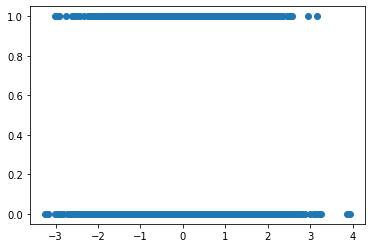

In [12]:
plt.scatter(X_df["x1"],y_1-y_0)

In [23]:
causal_selector.show_all_causality_information(True)

Propensity matching was included in fitting - Propensity information: 

Before matching auc 	 | mean (std) = 0.9921 (0.0009)
After matching auc 	 | mean (std) = 0.9268 (0.0058)
T0 all matched 146 samples
T1 all matched 1979 samples

Causality information:
TRAIN: 	 CATE = 0.1546563737474471 	| p-value = 0.0
VAL: 	 CATE = 0.15297648396152505 	| p-value = 0.0
Include all mode
CATE shap stats
----------------------------------------------------------------------
|                        |       impact |   p_value |   effect_size |   power_0.01_alpha |   0.99_power_its_req |
|:-----------------------|-------------:|----------:|--------------:|-------------------:|---------------------:|
| x8                     |  0.0771913   |      0    |    -7.24125   |          1         |              3.63459 |
| x7                     |  0.076446    |      0    |    -9.51286   |          1         |              3.27014 |
| T                      |  0.0206469   |      0.05 |    -3.34314   |          1 

In [148]:
# OLD CODE
run_old_cold = False
if run_old_cold:
    from scipy import stats
    from statsmodels.stats.power import TTestPower,FTestAnovaPower

    N = 5000 # 5000 or 800
    p = 50 #number of candidate biomarkers
    iterations = 10
    case = M2
    S_learner = True
    shap_prognost_predict = True

    pehes = []
    train_pehes = []
    mean_ITEs = []
    std_ITEs = []
    train_std_ITEs = []
    train_mean_ITEs = []
    shap_difs = np.array([])
    T0_shaps = np.array([])
    T0_shap_values_ar = np.array([])
    T1_shaps  = np.array([])
    T1_shap_values_ar = np.array([])
    T1_X_shap_ar = np.array([])
    T0_X_shap_ar = np.array([])

    columns_list = []
    for i in range(p):
        columns_list.append("x"+str(i+1))

    columns_list_with_random = columns_list+["random_uniform_feature"]

    npRandomState = RandomState(1)

    npRandomState_or = RandomState(42)

    """normal_mean = npRandomState_or.uniform(-1,1,1) #1#0 #np.pi
    x_features = np.array([])
    for i in range(p):
        if len(x_features)>0:
            x_features = np.vstack([x_features,npRandomState_or.normal(normal_mean,1,N)])
        else:
            x_features = npRandomState_or.normal(normal_mean,1,N)

    x_features = np.transpose(x_features)
    treatment_assignment = npRandomState.randint(0,2,N)

    npRandomState_or = RandomState(42)
    y = case(treatment_assignment,x_features,N,npRandomState_or)
    npRandomState_or = RandomState(42)
    y_0 = case(np.zeros(N),x_features,N,npRandomState_or)
    npRandomState_or = RandomState(42)
    y_1 = case(np.zeros(N)+1,x_features,N,npRandomState_or)"""

    for i in tqdm(range(iterations)):
        npRandomState = RandomState(i)

        random_uniform_feature = npRandomState.uniform(-1,1,N)

        #X_df = pd.DataFrame(data=x_features,columns=columns_list)
        #X_df = X_df.reset_index()
        #X_df["y"]=y
        #X_df["y_0"]=y_0
        #X_df["y_1"]=y_1
        #X_df["T"]=treatment_assignment
        X_df.loc[:,"random_uniform_feature"] = random_uniform_feature

        #indices_temp = X_df["index"].values
        #scaler = MinMaxScaler()
        #scaler.fit(X_df)
        #X_df = pd.DataFrame(data=scaler.transform(X_df),columns=X_df.columns)
        #X_df.loc[:,"index"]=indices_temp

        if S_learner:
            columns_list_current = columns_list_with_random + ["T"]
        else: 
            columns_list_current = columns_list_with_random

        train_index,test_index = train_test_split(X_df["index"].values,test_size=0.2,random_state=i,stratify=X_df["T"])
        #print(len(train_index))
        train_index_t,val_index = train_test_split(train_index,test_size=0.2,random_state=i,stratify=X_df[X_df["index"].isin(train_index)]["T"])
        #print(len(train_index))

        T0_X_train = X_df[(X_df["index"].isin(train_index))&(X_df["T"]==0)][columns_list_current]
        T0_X_val = X_df[(X_df["index"].isin(val_index))&(X_df["T"]==0)][columns_list_current]
        T0_X_test = X_df[(X_df["index"].isin(test_index))&(X_df["T"]==0)][columns_list_current]
        T1_X_train = X_df[(X_df["index"].isin(train_index))&(X_df["T"]==1)][columns_list_current]
        T1_X_val = X_df[(X_df["index"].isin(val_index))&(X_df["T"]==1)][columns_list_current]
        T1_X_test = X_df[(X_df["index"].isin(test_index))&(X_df["T"]==1)][columns_list_current]

        T0_y_train = X_df[(X_df["index"].isin(train_index))&(X_df["T"]==0)].y
        T0_y_val = X_df[(X_df["index"].isin(val_index))&(X_df["T"]==0)].y
        T0_y_test = X_df[(X_df["index"].isin(test_index))&(X_df["T"]==0)].y
        T1_y_train = X_df[(X_df["index"].isin(train_index))&(X_df["T"]==1)].y
        T1_y_val = X_df[(X_df["index"].isin(val_index))&(X_df["T"]==1)].y
        T1_y_test = X_df[(X_df["index"].isin(test_index))&(X_df["T"]==1)].y


        if S_learner:
            S_X_train = T0_X_train.append(T1_X_train)
            S_X_train_T1 = S_X_train.copy(deep=True)
            S_X_train_T1.loc[:,"T"] = 1
            S_X_train_T0 = S_X_train.copy(deep=True)
            S_X_train_T0.loc[:,"T"] = 0

            S_X_val = T0_X_val.append(T1_X_val)
            S_X_val_T1 = S_X_val.copy(deep=True)
            S_X_val_T1.loc[:,"T"] = 1
            S_X_val_T0 = S_X_val.copy(deep=True)
            S_X_val_T0.loc[:,"T"] = 0

            S_X_test = T0_X_test.append(T1_X_test)
            S_X_test_T1 = S_X_test.copy(deep=True)
            S_X_test_T1.loc[:,"T"] = 1
            S_X_test_T0 = S_X_test.copy(deep=True)
            S_X_test_T0.loc[:,"T"] = 0

            S_y_train = T0_y_train.append(T1_y_train)
            S_y_val = T0_y_val.append(T1_y_val)
            S_y_test = T0_y_test.append(T1_y_test)

            S_model = CatBoostRegressor(iterations=250,verbose=False,use_best_model=False)
            S_model.fit(S_X_train,S_y_train,eval_set=(S_X_val,S_y_val))

            ITE = S_model.predict(S_X_test_T1)-S_model.predict(S_X_test_T0)
            train_ITE = S_model.predict(S_X_train_T1)-S_model.predict(S_X_train_T0)

            C_explainer = shap.TreeExplainer(S_model)
            #T1_shap_values = C_explainer.shap_values(S_X_test_T1)
            #T0_shap_values = C_explainer.shap_values(S_X_test_T0)
            T1_shap_values = C_explainer.shap_values(S_X_val_T1)
            T0_shap_values = C_explainer.shap_values(S_X_val_T0)

            if len(T0_shap_values_ar)>0:
                T0_shap_values_ar = np.vstack([T0_shap_values_ar,T0_shap_values])
                T1_shap_values_ar = np.vstack([T1_shap_values_ar,T1_shap_values])
                #T1_X_shap_ar = np.vstack([T1_X_shap_ar,S_X_test_T1])
                #T0_X_shap_ar = np.vstack([T0_X_shap_ar,S_X_test_T0])
                T1_X_shap_ar = np.vstack([T1_X_shap_ar,S_X_val_T1])
                T0_X_shap_ar = np.vstack([T0_X_shap_ar,S_X_val_T0])
            else:
                T0_shap_values_ar = T0_shap_values
                T1_shap_values_ar = T1_shap_values
                #T1_X_shap_ar = S_X_test_T1
                #T0_X_shap_ar = S_X_test_T0
                T1_X_shap_ar = S_X_val_T1
                T0_X_shap_ar = S_X_val_T0

            #T1_shap_values = np.abs(T1_shap_values)
            #T0_shap_values = np.abs(T0_shap_values)

            ## includes predictive features, but not for features where the CATE = 0 but there is a large ITE (such as sinus)
            shap_diff_ar = np.mean(T1_shap_values-T0_shap_values+np.abs(T1_shap_values)-np.abs(T0_shap_values),axis=0)

            ## includes all relevant features
            #shap_diff_ar = np.mean(np.abs(T1_shap_values-T0_shap_values)+np.abs(T1_shap_values)-np.abs(T0_shap_values),axis=0)

            T1_shap_values = np.abs(T1_shap_values)
            T0_shap_values = np.abs(T0_shap_values)

            if len(shap_difs)>0:
                shap_difs = np.vstack([shap_difs,shap_diff_ar])
                T0_shaps = np.vstack([T0_shaps,np.mean(T0_shap_values,axis=0)])
                T1_shaps = np.vstack([T1_shaps,np.mean(T1_shap_values,axis=0)])
            else:
                shap_difs = shap_diff_ar
                T0_shaps = np.mean(T0_shap_values,axis=0)
                T1_shaps = np.mean(T1_shap_values,axis=0)

        else:
            Total_X_train = T0_X_train.append(T1_X_train)
            Total_X_test = T0_X_test.append(T1_X_test)
            Total_X_val = T0_X_val.append(T1_X_val)
            Total_y_val = T0_y_val.append(T1_y_val)
            Total_y_train = T0_y_train.append(T1_y_train)
            Total_y_test = T0_y_test.append(T1_y_test)

            T0_model = CatBoostRegressor(iterations=250,verbose=False,use_best_model=True)
            T0_model.fit(T0_X_train,T0_y_train,eval_set=(T0_X_val,T0_y_val))

            T1_model = CatBoostRegressor(iterations=250,verbose=False,use_best_model=True)
            T1_model.fit(T1_X_train,T1_y_train,eval_set=(T1_X_val,T1_y_val))

            ITE = T1_model.predict(Total_X_test)-T0_model.predict(Total_X_test)
            train_ITE = T1_model.predict(Total_X_train)-T0_model.predict(Total_X_train)

            T1_explainer = shap.TreeExplainer(T1_model)
            #T1_shap_values = T1_explainer.shap_values(Total_X_test)
            T1_shap_values = T1_explainer.shap_values(Total_X_val)

            T0_explainer = shap.TreeExplainer(T0_model)
            #T0_shap_values = T0_explainer.shap_values(Total_X_test)
            T0_shap_values = T0_explainer.shap_values(Total_X_val)

            if len(T0_shap_values_ar)>0:
                T0_shap_values_ar = np.vstack([T0_shap_values_ar,T0_shap_values])
                T1_shap_values_ar = np.vstack([T1_shap_values_ar,T1_shap_values])
                #T1_X_shap_ar = np.vstack([T1_X_shap_ar,Total_X_test])
                #T0_X_shap_ar = np.vstack([T0_X_shap_ar,Total_X_test])
                T1_X_shap_ar = np.vstack([T1_X_shap_ar,Total_X_val])
                T0_X_shap_ar = np.vstack([T0_X_shap_ar,Total_X_val])
            else:
                T0_shap_values_ar = T0_shap_values
                T1_shap_values_ar = T1_shap_values
                #T1_X_shap_ar = Total_X_test
                #T0_X_shap_ar = Total_X_test
                T1_X_shap_ar = Total_X_val
                T0_X_shap_ar = Total_X_val

            T1_shap_values = np.abs(T1_shap_values)
            T0_shap_values = np.abs(T0_shap_values)

            shap_diff_ar = np.mean(T1_shap_values-T0_shap_values+np.abs(T1_shap_values)-np.abs(T0_shap_values),axis=0)
            if len(shap_difs)>0:
                shap_difs = np.vstack([shap_difs,shap_diff_ar])
                T0_shaps = np.vstack([T0_shaps,np.mean(T0_shap_values,axis=0)])
                T1_shaps = np.vstack([T1_shaps,np.mean(T1_shap_values,axis=0)])
            else:
                shap_difs = shap_diff_ar
                T0_shaps = np.mean(T0_shap_values,axis=0)
                T1_shaps = np.mean(T1_shap_values,axis=0)

        pehes.append(normalized_epsilon_PEHE(np.append(X_df[(X_df["index"].isin(test_index))&(X_df["T"]==0)].y_1.values,X_df[(X_df["index"].isin(test_index))&(X_df["T"]==1)].y_1.values)
                                  ,np.append(X_df[(X_df["index"].isin(test_index))&(X_df["T"]==0)].y_0.values,X_df[(X_df["index"].isin(test_index))&(X_df["T"]==1)].y_0.values)
                                  ,ITE))
        train_pehes.append(normalized_epsilon_PEHE(np.append(X_df[(X_df["index"].isin(train_index))&(X_df["T"]==0)].y_1.values,X_df[(X_df["index"].isin(train_index))&(X_df["T"]==1)].y_1.values)
                                  ,np.append(X_df[(X_df["index"].isin(train_index))&(X_df["T"]==0)].y_0.values,X_df[(X_df["index"].isin(train_index))&(X_df["T"]==1)].y_0.values)
                                        ,train_ITE))

        mean_ITEs.append(np.mean(ITE))
        std_ITEs.append(np.std(ITE))
        train_mean_ITEs.append(np.mean(train_ITE))
        train_std_ITEs.append(np.std(train_ITE))


    #it does not matter which column array I pick, they all have the same
    if S_learner:
        shap_difs_pd = pd.DataFrame(data=shap_difs,columns=columns_list_current)
        T0_shaps_pd = pd.DataFrame(data=T0_shaps,columns=columns_list_current)
        T1_shaps_pd = pd.DataFrame(data=T1_shaps,columns=columns_list_current)
    else:
        shap_difs_pd = pd.DataFrame(data=shap_difs,columns=columns_list_current) 
        T0_shaps_pd = pd.DataFrame(data=T0_shaps,columns=columns_list_current) 
        T1_shaps_pd = pd.DataFrame(data=T1_shaps,columns=columns_list_current) 

    ########################################################################################################################################################   
    ## SHAP VALUE DIFFERENCE ANALYSIS
    p_values = []
    for i in range(len(shap_difs_pd.columns)):
        quantile = p_values_null_coef(np.array(shap_difs_pd.values[:,i]))/100
        if quantile > 0.5:
            p_value = 1-quantile
        else:
            p_value = quantile
        p_values.append(p_value)

    processed_shap_diff_pd = pd.DataFrame(data=np.hstack([np.reshape(shap_difs_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_shap","p_value"],index=shap_difs_pd.mean().index)
    processed_shap_diff_pd = processed_shap_diff_pd.reindex(processed_shap_diff_pd.mean_shap.abs().sort_values(ascending=False).index)

    ## SHAP VALUE DIFFERENCE ANALYSIS
    p_values = []
    effect_size = []
    power_list = []
    required_iterations = []
    power_alpha=0.01
    n_samples = len(T0_shaps_pd["random_uniform_feature"].values)
    for i in range(len(T0_shaps_pd.columns)):
        if shap_prognost_predict:
            mean_random_uniform = T0_shaps_pd["random_uniform_feature"].values.mean()
            quantile = p_values_arg_coef(np.array(T0_shaps_pd.values[:,i]),mean_random_uniform)/100
            p_value = quantile
            pooled_standard_deviation = np.sqrt(
                (
                    (T0_shaps_pd.std()[i] ** 2) * (n_samples - 1)
                    + (n_samples - 1)
                    * (T0_shaps_pd["random_uniform_feature"].values.std() ** 2)
                )
                / (n_samples * 2 - 2)
            )
            effect_size.append(
                (np.abs(T0_shaps_pd.mean()[i] - mean_random_uniform))
                / pooled_standard_deviation
            )
            power_list.append(
                TTestPower().power(
                    effect_size=effect_size[-1],
                    nobs=n_samples,
                    alpha=power_alpha,
                    df=None,
                    alternative="larger",
                )
            )
            if T0_shaps_pd.columns[i] == "random_uniform_feature":
                required_iterations.append(0)
            else:
                required_iterations.append(
                    TTestPower().solve_power(
                        effect_size=effect_size[-1],
                        nobs=None,
                        alpha=power_alpha,
                        power=0.95,
                        alternative="larger",
                    )
                )
        else:
            quantile = p_values_null_coef(np.array(T0_shaps_pd.values[:,i]))/100
            if quantile > 0.5:
                p_value = 1-quantile
            else:
                p_value = quantile
        p_values.append(p_value)

    processed_T0_shaps_pd = pd.DataFrame(data=np.hstack([np.reshape(T0_shaps_pd.mean().values,(-1,1)),
                                                         np.reshape(np.array(p_values),(len(p_values),1)),
                                                        np.reshape(np.array(effect_size), (len(effect_size), 1)),
                                                        np.reshape(np.array(power_list), (len(power_list), 1)),
                                                        np.reshape(
                                                            np.array(required_iterations), (len(required_iterations), 1)
                                                        ),]),
                                         columns=["mean_absolute_shap","p_value","effect_size","power","req_iterations"],index=T0_shaps_pd.mean().index)
    processed_T0_shaps_pd = processed_T0_shaps_pd.reindex(processed_T0_shaps_pd.mean_absolute_shap.abs().sort_values(ascending=False).index)

    ## SHAP VALUE DIFFERENCE ANALYSIS
    p_values = []
    for i in range(len(T1_shaps_pd.columns)):
        if shap_prognost_predict:
            mean_random_uniform = T1_shaps_pd["random_uniform_feature"].values.mean()
            quantile = p_values_arg_coef(np.array(T1_shaps_pd.values[:,i]),mean_random_uniform)/100
            p_value = quantile
        else:
            quantile = p_values_null_coef(np.array(T1_shaps_pd.values[:,i]))/100
            if quantile > 0.5:
                p_value = 1-quantile
            else:
                p_value = quantile
        p_values.append(p_value)

    processed_T1_shaps_pd = pd.DataFrame(data=np.hstack([np.reshape(T1_shaps_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_absolute_shap","p_value"],index=T1_shaps_pd.mean().index)
    processed_T1_shaps_pd = processed_T1_shaps_pd.reindex(processed_T1_shaps_pd.mean_absolute_shap.abs().sort_values(ascending=False).index)
    ########################################################################################################################################################   

    ## RESULT PRINTING
    print("")       
    print("TRAINING SET")
    quantile = p_values_null_coef(np.array(train_mean_ITEs))/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile

    print(tabulate([[str(np.round(np.mean(train_pehes),5))+" (+-"+str(np.round(np.std(train_pehes),5))+")",str(np.round(np.mean(train_mean_ITEs),5))+" (+-"+str(np.round(np.std(train_mean_ITEs),5))+")",str(np.round(np.mean(train_std_ITEs),5))+" (+-"+str(np.round(np.std(train_std_ITEs),5))+")",p_value]], ["PEHE (std)","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))

    print("")       
    print("TEST SET")
    quantile = p_values_null_coef(np.array(mean_ITEs))/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile

    print(tabulate([[str(np.round(np.mean(pehes),5))+" (+-"+str(np.round(np.std(pehes),5))+")", str(np.round(np.mean(mean_ITEs),5))+" (+-"+str(np.round(np.std(mean_ITEs),5))+")",str(np.round(np.mean(std_ITEs),5))+" (+-"+str(np.round(np.std(std_ITEs),5))+")",p_value]], ["PEHE (std)","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))
    
    for i in range(p):
        print("feature: "+str(columns_list_current[i]))
        print("p-value: "+str(stats.kstest(T1_shaps[:,i],T0_shaps[:,i])[1] ))
        print(50*"=")
    
    processed_T1_shaps_pd[processed_T1_shaps_pd.p_value<0.05]
    processed_T0_shaps_pd[processed_T0_shaps_pd.p_value<0.05]
    processed_shap_diff_pd[processed_shap_diff_pd.p_value<0.05]

In [ ]:
plt.hist(T1_shap_values_ar[:,list(idx[0])],density=True,label="T1")
plt.hist(T0_shap_values_ar[:,list(idx[0])],density=True,label="T0",alpha=0.5)
plt.legend()

In [ ]:
plt.hist(np.abs(T1_shap_values_ar[:,list(idx[0])]),density=True,label="T1")
plt.hist(np.abs(T0_shap_values_ar[:,list(idx[0])]),density=True,label="T0",alpha=0.5)
plt.legend()

In [ ]:
idx = np.where(np.isin(columns_list_current,"T"))

In [ ]:
plt.hist(T1_shap_values_ar[:,list(idx[0])],density=True,label="T1")
plt.hist(T0_shap_values_ar[:,list(idx[0])],density=True,label="T0",alpha=0.5)
plt.legend()

In [ ]:
plt.hist(np.abs(T1_shap_values_ar[:,list(idx[0])]),density=True,label="T1")
plt.hist(np.abs(T0_shap_values_ar[:,list(idx[0])]),density=True,label="T0",alpha=0.5)
plt.legend()

#### NEURAL NETWORK

In [4]:
import tensorflow as tf
from tqdm.keras import TqdmCallback

#@activationFunction: "relu","tanh","sigmoid"
class NN_model(tf.keras.Model):
    def __init__(self,Layer_structure,activationFunction="relu"):
        super(NN_model,self).__init__()

        ff_shape = len(Layer_structure)
        
        self.ff_layers = []

        for ff_layer_i in range(ff_shape):
            self.ff_layers.append(tf.keras.layers.Dense(Layer_structure[ff_layer_i], name="ff_layer_"+str(ff_layer_i) ,activation=activationFunction))

        self.y = tf.keras.layers.Dense(1, activation="linear",name="final_layer")

    def call(self,inputs):
        ffik = self.ff_layers[0](inputs)
        for ff_layer in self.ff_layers[1:]:
            ffik = ff_layer(ffik)

        return self.y(ffik)


    def predict(self,inputs):
        return self.call(inputs)
    
#@activationFunction: "relu","tanh","sigmoid"
def NN_model(NNinputs,Layer_structure,activationFunction="relu"):
    #pass the input into the first layer

    ffik = tf.keras.layers.Dense(Layer_structure[0], activation=activationFunction)(NNinputs)
    ffiks = [ffik]
    for ff_layer_i in range(len(Layer_structure)-1):
            ffiks.append(tf.keras.layers.Dense(Layer_structure[ff_layer_i+1], activation=activationFunction)(ffiks[-1]))

    y = tf.keras.layers.Dense(1, activation="linear",name="final_layer")(ffiks[-1])

    model = tf.keras.Model(inputs=NNinputs, outputs=y, name="NN_model")
    
    return model

In [5]:
LEARNING_RATE = 0.001 #0.001#25
DECAY = 0.99
N_EPOCHS = 100
BATCH_SIZE = 256 #256 #2048

In [6]:
N = 5000 # 5000 or 800
p = 300 #number of candidate biomarkers
iterations = 200
case = M1
S_learner = True
shap_prognost_predict = True

layer_structure = [128,64,32]

pehes = []
train_pehes = []
mean_ITEs = []
std_ITEs = []
train_std_ITEs = []
train_mean_ITEs = []
shap_difs = np.array([])
T0_shaps = np.array([])
T0_shap_values_ar = np.array([])
T1_shaps  = np.array([])
T1_shap_values_ar = np.array([])
T1_X_shap_ar = np.array([])
T0_X_shap_ar = np.array([])

columns_list = []
for i in range(p):
    columns_list.append("x"+str(i+1))

columns_list_with_random = columns_list+["random_uniform_feature"]

npRandomState_or = RandomState(42)

normal_mean = 0.5 #npRandomState_or.uniform(-1,1,1) #1#0 #np.pi
x_features = np.array([])
for i in range(p):
    if len(x_features)>0:
        x_features = np.vstack([x_features,npRandomState_or.normal(normal_mean,1,N)])
    else:
        x_features = npRandomState_or.normal(normal_mean,1,N)

x_features = np.transpose(x_features)


for i in tqdm(range(iterations)):
    npRandomState = RandomState(i)
    
    treatment_assignment = npRandomState.randint(0,2,N)
    random_uniform_feature = npRandomState.normal(0,1,N)#npRandomState.uniform(-1,1,N)

    npRandomState_or = RandomState(42)
    y = case(treatment_assignment,x_features,N,npRandomState_or)
    npRandomState_or = RandomState(42)
    y_0 = case(np.zeros(N),x_features,N,npRandomState_or)
    npRandomState_or = RandomState(42)
    y_1 = case(np.zeros(N)+1,x_features,N,npRandomState_or)
    
    X_df = pd.DataFrame(data=x_features,columns=columns_list)
    X_df = X_df.reset_index()
    X_df["y"]=y
    X_df["y_0"]=y_0
    X_df["y_1"]=y_1
    X_df["T"]=treatment_assignment
    X_df["random_uniform_feature"]=random_uniform_feature
    
    #indices_temp = X_df["index"].values
    #scaler = MinMaxScaler()
    #scaler.fit(X_df)
    #X_df = pd.DataFrame(data=scaler.transform(X_df),columns=X_df.columns)
    #X_df.loc[:,"index"]=indices_temp
    
    if S_learner:
        columns_list_current = columns_list_with_random + ["T"]
    else: 
        columns_list_current = columns_list_with_random
    
    train_index,test_index = train_test_split(X_df["index"].values,test_size=0.2,random_state=i,stratify=X_df["T"])
    train_index,val_index = train_test_split(train_index,test_size=0.2,random_state=i,stratify=X_df[X_df["index"].isin(train_index)]["T"])
    
    T0_X_train = X_df[(X_df["index"].isin(train_index))&(X_df["T"]==0)][columns_list_current]
    T0_X_val = X_df[(X_df["index"].isin(val_index))&(X_df["T"]==0)][columns_list_current]
    T0_X_test = X_df[(X_df["index"].isin(test_index))&(X_df["T"]==0)][columns_list_current]
    T1_X_train = X_df[(X_df["index"].isin(train_index))&(X_df["T"]==1)][columns_list_current]
    T1_X_val = X_df[(X_df["index"].isin(val_index))&(X_df["T"]==1)][columns_list_current]
    T1_X_test = X_df[(X_df["index"].isin(test_index))&(X_df["T"]==1)][columns_list_current]
    
    T0_y_train = X_df[(X_df["index"].isin(train_index))&(X_df["T"]==0)].y
    T0_y_val = X_df[(X_df["index"].isin(val_index))&(X_df["T"]==0)].y
    T0_y_test = X_df[(X_df["index"].isin(test_index))&(X_df["T"]==0)].y
    T1_y_train = X_df[(X_df["index"].isin(train_index))&(X_df["T"]==1)].y
    T1_y_val = X_df[(X_df["index"].isin(val_index))&(X_df["T"]==1)].y
    T1_y_test = X_df[(X_df["index"].isin(test_index))&(X_df["T"]==1)].y
    
    
    if S_learner:
        S_X_train = T0_X_train.append(T1_X_train).sample(len(T0_X_train)+len(T1_X_train),replace=False,random_state=i)
        S_X_train_T1 = S_X_train.copy(deep=True)
        S_X_train_T1.loc[:,"T"] = 1
        S_X_train_T0 = S_X_train.copy(deep=True)
        S_X_train_T0.loc[:,"T"] = 0
        
        S_X_val = T0_X_val.append(T1_X_val)
        S_X_val_T1 = S_X_val.copy(deep=True)
        S_X_val_T1.loc[:,"T"] = 1
        S_X_val_T0 = S_X_val.copy(deep=True)
        S_X_val_T0.loc[:,"T"] = 0
        
        S_X_test = T0_X_test.append(T1_X_test)
        S_X_test_T1 = S_X_test.copy(deep=True)
        S_X_test_T1.loc[:,"T"] = 1
        S_X_test_T0 = S_X_test.copy(deep=True)
        S_X_test_T0.loc[:,"T"] = 0
        
        S_y_train = T0_y_train.append(T1_y_train).sample(len(T0_X_train)+len(T1_X_train),replace=False,random_state=i)
        S_y_val = T0_y_val.append(T1_y_val)
        S_y_test = T0_y_test.append(T1_y_test)
        
        
        S_model = NN_model(tf.keras.Input(shape=(np.shape(S_X_train.values)[1],)),layer_structure,"relu")#best_params['Flayer'],best_params['Slayer'],best_params['Tlayer'],"relu")#128,64,64
        S_model.compile(
            loss="MSE",
            optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=DECAY),
            metrics=[tf.keras.metrics.MeanSquaredError()], 
        )
        S_model.fit(S_X_train.values,S_y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(S_X_val.values,S_y_val),verbose=0)#, callbacks=[TqdmCallback(verbose=0)])
        
        ITE = S_model.predict(S_X_test_T1.values)-S_model.predict(S_X_test_T0.values)
        train_ITE = S_model.predict(S_X_train_T1.values)-S_model.predict(S_X_train_T0.values)

        C_explainer = shap.DeepExplainer(S_model,S_X_train.values)
        #T1_shap_values = C_explainer.shap_values(S_X_test_T1)
        #T0_shap_values = C_explainer.shap_values(S_X_test_T0)
        T1_shap_values = C_explainer.shap_values(S_X_val_T1.values)[0]
        T0_shap_values = C_explainer.shap_values(S_X_val_T0.values)[0]
        
        if len(T0_shap_values_ar)>0:
            T0_shap_values_ar = np.vstack([T0_shap_values_ar,T0_shap_values])
            T1_shap_values_ar = np.vstack([T1_shap_values_ar,T1_shap_values])
            #T1_X_shap_ar = np.vstack([T1_X_shap_ar,S_X_test_T1])
            #T0_X_shap_ar = np.vstack([T0_X_shap_ar,S_X_test_T0])
            T1_X_shap_ar = np.vstack([T1_X_shap_ar,S_X_val_T1])
            T0_X_shap_ar = np.vstack([T0_X_shap_ar,S_X_val_T0])
        else:
            T0_shap_values_ar = T0_shap_values
            T1_shap_values_ar = T1_shap_values
            #T1_X_shap_ar = S_X_test_T1
            #T0_X_shap_ar = S_X_test_T0
            T1_X_shap_ar = S_X_val_T1
            T0_X_shap_ar = S_X_val_T0

        #T1_shap_values = np.abs(T1_shap_values)
        #T0_shap_values = np.abs(T0_shap_values)
        
        ## includes predictive features, but not for features where the CATE = 0 but there is a large ITE (such as sinus)
        shap_diff_ar = np.mean(T1_shap_values-T0_shap_values+np.abs(T1_shap_values)-np.abs(T0_shap_values),axis=0)
        
        ## includes all relevant features
        #shap_diff_ar = np.mean(np.abs(T1_shap_values-T0_shap_values)+np.abs(T1_shap_values)-np.abs(T0_shap_values),axis=0)
        
        T1_shap_values = np.abs(T1_shap_values)
        T0_shap_values = np.abs(T0_shap_values)
        
        if len(shap_difs)>0:
            shap_difs = np.vstack([shap_difs,shap_diff_ar])
            T0_shaps = np.vstack([T0_shaps,np.mean(T0_shap_values,axis=0)])
            T1_shaps = np.vstack([T1_shaps,np.mean(T1_shap_values,axis=0)])
        else:
            shap_difs = shap_diff_ar
            T0_shaps = np.mean(T0_shap_values,axis=0)
            T1_shaps = np.mean(T1_shap_values,axis=0)
        
    else:
        Total_X_train = T0_X_train.append(T1_X_train)
        Total_X_test = T0_X_test.append(T1_X_test)
        Total_X_val = T0_X_val.append(T1_X_val)
        Total_y_val = T0_y_val.append(T1_y_val)
        Total_y_train = T0_y_train.append(T1_y_train)
        Total_y_test = T0_y_test.append(T1_y_test)

        T0_model = NN_model(tf.keras.Input(shape=(np.shape(T0_X_train.values)[1],)),layer_structure,"relu")#best_params['Flayer'],best_params['Slayer'],best_params['Tlayer'],"relu")#128,64,64
        T0_model.compile(
            loss="MSE",
            optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=DECAY),
            metrics=[tf.keras.metrics.MeanSquaredError()], 
        )
        T0_model.fit(T0_X_train.values,T0_y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(T0_X_val.values,T0_y_val),verbose=0)#, callbacks=[TqdmCallback(verbose=1)])
        
        T1_model = NN_model(tf.keras.Input(shape=(np.shape(T1_X_train.values)[1],)),layer_structure,"relu")#best_params['Flayer'],best_params['Slayer'],best_params['Tlayer'],"relu")#128,64,64
        T1_model.compile(
            loss="MSE",
            optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=DECAY),
            metrics=[tf.keras.metrics.MeanSquaredError()], 
        )
        T1_model.fit(T1_X_train.values,T1_y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(T1_X_val.values,T1_y_val),verbose=0)#, callbacks=[TqdmCallback(verbose=1)])
        
        ITE = T1_model.predict(Total_X_test.values)-T0_model.predict(Total_X_test.values)
        train_ITE = T1_model.predict(Total_X_train.values)-T0_model.predict(Total_X_train.values)

        T1_explainer = shap.DeepExplainer(T1_model,T1_X_train.values)
        #T1_shap_values = T1_explainer.shap_values(Total_X_test)
        T1_shap_values = T1_explainer.shap_values(Total_X_val.values)[0]
        
        T0_explainer = shap.DeepExplainer(T0_model,T0_X_train.values)
        #T0_shap_values = T0_explainer.shap_values(Total_X_test)
        T0_shap_values = T0_explainer.shap_values(Total_X_val.values)[0]
            
        if len(T0_shap_values_ar)>0:
            T0_shap_values_ar = np.vstack([T0_shap_values_ar,T0_shap_values])
            T1_shap_values_ar = np.vstack([T1_shap_values_ar,T1_shap_values])
            #T1_X_shap_ar = np.vstack([T1_X_shap_ar,Total_X_test])
            #T0_X_shap_ar = np.vstack([T0_X_shap_ar,Total_X_test])
            T1_X_shap_ar = np.vstack([T1_X_shap_ar,Total_X_val])
            T0_X_shap_ar = np.vstack([T0_X_shap_ar,Total_X_val])
        else:
            T0_shap_values_ar = T0_shap_values
            T1_shap_values_ar = T1_shap_values
            #T1_X_shap_ar = Total_X_test
            #T0_X_shap_ar = Total_X_test
            T1_X_shap_ar = Total_X_val
            T0_X_shap_ar = Total_X_val
        
        T1_shap_values = np.abs(T1_shap_values)
        T0_shap_values = np.abs(T0_shap_values)
        
        shap_diff_ar = np.mean(T1_shap_values-T0_shap_values+np.abs(T1_shap_values)-np.abs(T0_shap_values),axis=0)
        if len(shap_difs)>0:
            shap_difs = np.vstack([shap_difs,shap_diff_ar])
            T0_shaps = np.vstack([T0_shaps,np.mean(T0_shap_values,axis=0)])
            T1_shaps = np.vstack([T1_shaps,np.mean(T1_shap_values,axis=0)])
        else:
            shap_difs = shap_diff_ar
            T0_shaps = np.mean(T0_shap_values,axis=0)
            T1_shaps = np.mean(T1_shap_values,axis=0)
            
    pehes.append(normalized_epsilon_PEHE(np.append(X_df[(X_df["index"].isin(test_index))&(X_df["T"]==0)].y_1.values,X_df[(X_df["index"].isin(test_index))&(X_df["T"]==1)].y_1.values)
                              ,np.append(X_df[(X_df["index"].isin(test_index))&(X_df["T"]==0)].y_0.values,X_df[(X_df["index"].isin(test_index))&(X_df["T"]==1)].y_0.values)
                              ,ITE[:,0]))
    train_pehes.append(normalized_epsilon_PEHE(np.append(X_df[(X_df["index"].isin(train_index))&(X_df["T"]==0)].y_1.values,X_df[(X_df["index"].isin(train_index))&(X_df["T"]==1)].y_1.values)
                              ,np.append(X_df[(X_df["index"].isin(train_index))&(X_df["T"]==0)].y_0.values,X_df[(X_df["index"].isin(train_index))&(X_df["T"]==1)].y_0.values)
                                    ,train_ITE[:,0]))
            
    mean_ITEs.append(np.mean(ITE))
    std_ITEs.append(np.std(ITE))
    train_mean_ITEs.append(np.mean(train_ITE))
    train_std_ITEs.append(np.std(train_ITE))
    

#it does not matter which column array I pick, they all have the same
if S_learner:
    shap_difs_pd = pd.DataFrame(data=shap_difs,columns=columns_list_current)
    T0_shaps_pd = pd.DataFrame(data=T0_shaps,columns=columns_list_current)
    T1_shaps_pd = pd.DataFrame(data=T1_shaps,columns=columns_list_current)
else:
    shap_difs_pd = pd.DataFrame(data=shap_difs,columns=columns_list_current) 
    T0_shaps_pd = pd.DataFrame(data=T0_shaps,columns=columns_list_current) 
    T1_shaps_pd = pd.DataFrame(data=T1_shaps,columns=columns_list_current) 
    
########################################################################################################################################################   
## SHAP VALUE DIFFERENCE ANALYSIS
p_values = []
for i in range(len(shap_difs_pd.columns)):
    quantile = p_values_null_coef(np.array(shap_difs_pd.values[:,i]))/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile
    p_values.append(p_value)
    
processed_shap_diff_pd = pd.DataFrame(data=np.hstack([np.reshape(shap_difs_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_shap","p_value"],index=shap_difs_pd.mean().index)
processed_shap_diff_pd = processed_shap_diff_pd.reindex(processed_shap_diff_pd.mean_shap.abs().sort_values(ascending=False).index)

## SHAP VALUE DIFFERENCE ANALYSIS
p_values = []
for i in range(len(T0_shaps_pd.columns)):
    if shap_prognost_predict:
        mean_random_uniform = T0_shaps_pd["random_uniform_feature"].values.mean()
        quantile = p_values_arg_coef(np.array(T0_shaps_pd.values[:,i]),mean_random_uniform)/100
        p_value = quantile
    else:
        quantile = p_values_null_coef(np.array(T0_shaps_pd.values[:,i]))/100
        if quantile > 0.5:
            p_value = 1-quantile
        else:
            p_value = quantile
    p_values.append(p_value)
    
processed_T0_shaps_pd = pd.DataFrame(data=np.hstack([np.reshape(T0_shaps_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_absolute_shap","p_value"],index=T0_shaps_pd.mean().index)
processed_T0_shaps_pd = processed_T0_shaps_pd.reindex(processed_T0_shaps_pd.mean_absolute_shap.abs().sort_values(ascending=False).index)

## SHAP VALUE DIFFERENCE ANALYSIS
p_values = []
for i in range(len(T1_shaps_pd.columns)):
    if shap_prognost_predict:
        mean_random_uniform = T1_shaps_pd["random_uniform_feature"].values.mean()
        quantile = p_values_arg_coef(np.array(T1_shaps_pd.values[:,i]),mean_random_uniform)/100
        p_value = quantile
    else:
        quantile = p_values_null_coef(np.array(T1_shaps_pd.values[:,i]))/100
        if quantile > 0.5:
            p_value = 1-quantile
        else:
            p_value = quantile
    p_values.append(p_value)
    
processed_T1_shaps_pd = pd.DataFrame(data=np.hstack([np.reshape(T1_shaps_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_absolute_shap","p_value"],index=T1_shaps_pd.mean().index)
processed_T1_shaps_pd = processed_T1_shaps_pd.reindex(processed_T1_shaps_pd.mean_absolute_shap.abs().sort_values(ascending=False).index)
########################################################################################################################################################   

## RESULT PRINTING
print("")       
print("TRAINING SET")
quantile = p_values_null_coef(np.array(train_mean_ITEs))/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile

print(tabulate([[str(np.round(np.mean(train_pehes),5))+" (+-"+str(np.round(np.std(train_pehes),5))+")",str(np.round(np.mean(train_mean_ITEs),5))+" (+-"+str(np.round(np.std(train_mean_ITEs),5))+")",str(np.round(np.mean(train_std_ITEs),5))+" (+-"+str(np.round(np.std(train_std_ITEs),5))+")",p_value]], ["PEHE (std)","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))
    
print("")       
print("TEST SET")
quantile = p_values_null_coef(np.array(mean_ITEs))/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile

print(tabulate([[str(np.round(np.mean(pehes),5))+" (+-"+str(np.round(np.std(pehes),5))+")", str(np.round(np.mean(mean_ITEs),5))+" (+-"+str(np.round(np.std(mean_ITEs),5))+")",str(np.round(np.mean(std_ITEs),5))+" (+-"+str(np.round(np.std(std_ITEs),5))+")",p_value]], ["PEHE (std)","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


keras is no longer supported, please use tf.keras instead.
100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [3:38:41<00:00, 65.61s/it]


TRAINING SET
+---------------------+---------------------+---------------------+---------------------+
| PEHE (std)          | ATE (std)           | STD ITE (std)       |   p-Value Treatment |
+=====================+=====================+=====================+=====================+
| 0.00451 (+-0.00027) | 0.43891 (+-0.01774) | 0.03798 (+-0.00915) |                   0 |
+---------------------+---------------------+---------------------+---------------------+

TEST SET
+---------------------+---------------------+--------------------+---------------------+
| PEHE (std)          | ATE (std)           | STD ITE (std)      |   p-Value Treatment |
+=====================+=====================+====================+=====================+
| 0.00524 (+-0.00056) | 0.43708 (+-0.01767) | 0.03988 (+-0.0093) |                   0 |
+---------------------+---------------------+--------------------+---------------------+


In [7]:
processed_T1_shaps_pd[processed_T1_shaps_pd.p_value<0.05]

,mean_absolute_shap,p_value
x1,3.144911,0.0
x2,2.396399,0.0
x4,2.376514,0.0
x3,2.365746,0.0
x5,2.342088,0.0
T,0.221871,0.0
x7,0.093994,0.0
x8,0.090820,0.0


In [8]:
processed_T0_shaps_pd[processed_T0_shaps_pd.p_value<0.05]

,mean_absolute_shap,p_value
x1,3.144307,0.0
x2,2.395781,0.0
x4,2.375899,0.0
x3,2.365166,0.0
x5,2.341476,0.0
T,0.221868,0.0
x7,0.093667,0.0
x8,0.090500,0.0


In [5]:
processed_shap_diff_pd[processed_shap_diff_pd.p_value<0.05]

NameError: name 'processed_shap_diff_pd' is not defined

### Linear Regression

In [4]:
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

In [5]:
N = 5000 # 5000 or 800
p = 100 #number of candidate biomarkers
iterations = 200
case = M12
S_learner = True
shap_prognost_predict = True

pehes = []
train_pehes = []
mean_ITEs = []
std_ITEs = []
train_std_ITEs = []
train_mean_ITEs = []
shap_difs = np.array([])
T0_shaps = np.array([])
T0_shap_values_ar = np.array([])
T1_shaps  = np.array([])
T1_shap_values_ar = np.array([])
T1_X_shap_ar = np.array([])
T0_X_shap_ar = np.array([])

columns_list = []
for i in range(p):
    columns_list.append("x"+str(i+1))

columns_list_with_random = columns_list+["random_uniform_feature"]

npRandomState_or = RandomState(42)

normal_mean = npRandomState_or.uniform(-1,1,1) #1#0 #np.pi
x_features = np.array([])
for i in range(p):
    if len(x_features)>0:
        x_features = np.vstack([x_features,npRandomState_or.normal(normal_mean,1,N)])
    else:
        x_features = npRandomState_or.normal(normal_mean,1,N)

x_features = np.transpose(x_features)


for i in tqdm(range(iterations)):
    npRandomState = RandomState(i)
    
    treatment_assignment = npRandomState.randint(0,2,N)
    random_uniform_feature = npRandomState.normal(0,1,N)#uniform(-1,1,N)

    npRandomState_or = RandomState(42)
    y = case(treatment_assignment,x_features,N,npRandomState_or)
    npRandomState_or = RandomState(42)
    y_0 = case(np.zeros(N),x_features,N,npRandomState_or)
    npRandomState_or = RandomState(42)
    y_1 = case(np.zeros(N)+1,x_features,N,npRandomState_or)
    
    X_df = pd.DataFrame(data=x_features,columns=columns_list)
    X_df = X_df.reset_index()
    X_df["y"]=y
    X_df["y_0"]=y_0
    X_df["y_1"]=y_1
    X_df["T"]=treatment_assignment
    X_df["random_uniform_feature"]=random_uniform_feature
    
    #indices_temp = X_df["index"].values
    #scaler = MinMaxScaler()
    #scaler.fit(X_df)
    #X_df = pd.DataFrame(data=scaler.transform(X_df),columns=X_df.columns)
    #X_df.loc[:,"index"]=indices_temp
    
    if S_learner:
        columns_list_current = columns_list_with_random + ["T"]
    else: 
        columns_list_current = columns_list_with_random
    
    train_index,test_index = train_test_split(X_df["index"].values,test_size=0.1,random_state=i,stratify=X_df["T"])
    #print(len(train_index))
    train_index,val_index = train_test_split(train_index,test_size=0.2,random_state=i,stratify=X_df[X_df["index"].isin(train_index)]["T"])
    #print(len(train_index))
    
    T0_X_train = X_df[(X_df["index"].isin(train_index))&(X_df["T"]==0)][columns_list_current]
    T0_X_val = X_df[(X_df["index"].isin(val_index))&(X_df["T"]==0)][columns_list_current]
    T0_X_test = X_df[(X_df["index"].isin(test_index))&(X_df["T"]==0)][columns_list_current]
    T1_X_train = X_df[(X_df["index"].isin(train_index))&(X_df["T"]==1)][columns_list_current]
    T1_X_val = X_df[(X_df["index"].isin(val_index))&(X_df["T"]==1)][columns_list_current]
    T1_X_test = X_df[(X_df["index"].isin(test_index))&(X_df["T"]==1)][columns_list_current]
    
    T0_y_train = X_df[(X_df["index"].isin(train_index))&(X_df["T"]==0)].y
    T0_y_val = X_df[(X_df["index"].isin(val_index))&(X_df["T"]==0)].y
    T0_y_test = X_df[(X_df["index"].isin(test_index))&(X_df["T"]==0)].y
    T1_y_train = X_df[(X_df["index"].isin(train_index))&(X_df["T"]==1)].y
    T1_y_val = X_df[(X_df["index"].isin(val_index))&(X_df["T"]==1)].y
    T1_y_test = X_df[(X_df["index"].isin(test_index))&(X_df["T"]==1)].y
    
    
    if S_learner:
        S_X_train = T0_X_train.append(T1_X_train)
        S_X_train_T1 = S_X_train.copy(deep=True)
        S_X_train_T1.loc[:,"T"] = 1
        S_X_train_T0 = S_X_train.copy(deep=True)
        S_X_train_T0.loc[:,"T"] = 0
        
        S_X_val = T0_X_val.append(T1_X_val)
        S_X_val_T1 = S_X_val.copy(deep=True)
        S_X_val_T1.loc[:,"T"] = 1
        S_X_val_T0 = S_X_val.copy(deep=True)
        S_X_val_T0.loc[:,"T"] = 0
        
        S_X_test = T0_X_test.append(T1_X_test)
        S_X_test_T1 = S_X_test.copy(deep=True)
        S_X_test_T1.loc[:,"T"] = 1
        S_X_test_T0 = S_X_test.copy(deep=True)
        S_X_test_T0.loc[:,"T"] = 0
        
        S_y_train = T0_y_train.append(T1_y_train)
        S_y_val = T0_y_val.append(T1_y_val)
        S_y_test = T0_y_test.append(T1_y_test)
        
        S_model = Pipeline(
        [
            ("scale", RobustScaler()),
            ("model", Ridge(alpha=0.1)),
        ])
        
        #S_model = Ridge()
        S_model.fit(S_X_train,S_y_train)
        
        ITE = S_model.predict(S_X_test_T1)-S_model.predict(S_X_test_T0)
        train_ITE = S_model.predict(S_X_train_T1)-S_model.predict(S_X_train_T0)
        
        C_explainer = shap.explainers.Linear(S_model['model'],S_X_train)
        #T1_shap_values = C_explainer.shap_values(S_X_test_T1)
        #T0_shap_values = C_explainer.shap_values(S_X_test_T0)
        T1_shap_values = C_explainer.shap_values(S_X_val_T1)
        T0_shap_values = C_explainer.shap_values(S_X_val_T0)
        
        if len(T0_shap_values_ar)>0:
            T0_shap_values_ar = np.vstack([T0_shap_values_ar,T0_shap_values])
            T1_shap_values_ar = np.vstack([T1_shap_values_ar,T1_shap_values])
            #T1_X_shap_ar = np.vstack([T1_X_shap_ar,S_X_test_T1])
            #T0_X_shap_ar = np.vstack([T0_X_shap_ar,S_X_test_T0])
            T1_X_shap_ar = np.vstack([T1_X_shap_ar,S_X_val_T1])
            T0_X_shap_ar = np.vstack([T0_X_shap_ar,S_X_val_T0])
        else:
            T0_shap_values_ar = T0_shap_values
            T1_shap_values_ar = T1_shap_values
            #T1_X_shap_ar = S_X_test_T1
            #T0_X_shap_ar = S_X_test_T0
            T1_X_shap_ar = S_X_val_T1
            T0_X_shap_ar = S_X_val_T0

        #T1_shap_values = np.abs(T1_shap_values)
        #T0_shap_values = np.abs(T0_shap_values)
        
        ## includes predictive features, but not for features where the CATE = 0 but there is a large ITE (such as sinus)
        shap_diff_ar = np.mean(T1_shap_values-T0_shap_values+np.abs(T1_shap_values)-np.abs(T0_shap_values),axis=0)
        
        ## includes all relevant features
        #shap_diff_ar = np.mean(np.abs(T1_shap_values-T0_shap_values)+np.abs(T1_shap_values)-np.abs(T0_shap_values),axis=0)
        
        T1_shap_values = np.abs(T1_shap_values)
        T0_shap_values = np.abs(T0_shap_values)
        
        if len(shap_difs)>0:
            shap_difs = np.vstack([shap_difs,shap_diff_ar])
            T0_shaps = np.vstack([T0_shaps,np.mean(T0_shap_values,axis=0)])
            T1_shaps = np.vstack([T1_shaps,np.mean(T1_shap_values,axis=0)])
        else:
            shap_difs = shap_diff_ar
            T0_shaps = np.mean(T0_shap_values,axis=0)
            T1_shaps = np.mean(T1_shap_values,axis=0)
        
    else:
        Total_X_train = T0_X_train.append(T1_X_train)
        Total_X_test = T0_X_test.append(T1_X_test)
        Total_X_val = T0_X_val.append(T1_X_val)
        Total_y_val = T0_y_val.append(T1_y_val)
        Total_y_train = T0_y_train.append(T1_y_train)
        Total_y_test = T0_y_test.append(T1_y_test)
        
        T0_model = Pipeline(
        [
            ("scale", RobustScaler()),
            ("model", Ridge()),
        ])
        
        T1_model = Pipeline(
        [
            ("scale", RobustScaler()),
            ("model", Ridge()),
        ])
        
        #S_model = Ridge()
        T0_model.fit(T0_X_train,T0_y_train)
        T1_model.fit(T1_X_train,T1_y_train)
        
        ITE = T1_model.predict(Total_X_test)-T0_model.predict(Total_X_test)
        train_ITE = T1_model.predict(Total_X_train)-T0_model.predict(Total_X_train)

        T1_explainer = shap.explainers.Linear(T1_model['model'],T1_X_train)
        #T1_shap_values = T1_explainer.shap_values(Total_X_test)
        T1_shap_values = T1_explainer.shap_values(Total_X_val)
        
        T0_explainer = shap.explainers.Linear(T0_model['model'],T0_X_train)
        #T0_shap_values = T0_explainer.shap_values(Total_X_test)
        T0_shap_values = T0_explainer.shap_values(Total_X_val)
            
        if len(T0_shap_values_ar)>0:
            T0_shap_values_ar = np.vstack([T0_shap_values_ar,T0_shap_values])
            T1_shap_values_ar = np.vstack([T1_shap_values_ar,T1_shap_values])
            #T1_X_shap_ar = np.vstack([T1_X_shap_ar,Total_X_test])
            #T0_X_shap_ar = np.vstack([T0_X_shap_ar,Total_X_test])
            T1_X_shap_ar = np.vstack([T1_X_shap_ar,Total_X_val])
            T0_X_shap_ar = np.vstack([T0_X_shap_ar,Total_X_val])
        else:
            T0_shap_values_ar = T0_shap_values
            T1_shap_values_ar = T1_shap_values
            #T1_X_shap_ar = Total_X_test
            #T0_X_shap_ar = Total_X_test
            T1_X_shap_ar = Total_X_val
            T0_X_shap_ar = Total_X_val
        
        T1_shap_values = np.abs(T1_shap_values)
        T0_shap_values = np.abs(T0_shap_values)
        
        shap_diff_ar = np.mean(T1_shap_values-T0_shap_values+np.abs(T1_shap_values)-np.abs(T0_shap_values),axis=0)
        if len(shap_difs)>0:
            shap_difs = np.vstack([shap_difs,shap_diff_ar])
            T0_shaps = np.vstack([T0_shaps,np.mean(T0_shap_values,axis=0)])
            T1_shaps = np.vstack([T1_shaps,np.mean(T1_shap_values,axis=0)])
        else:
            shap_difs = shap_diff_ar
            T0_shaps = np.mean(T0_shap_values,axis=0)
            T1_shaps = np.mean(T1_shap_values,axis=0)
            
    pehes.append(normalized_epsilon_PEHE(np.append(X_df[(X_df["index"].isin(test_index))&(X_df["T"]==0)].y_1.values,X_df[(X_df["index"].isin(test_index))&(X_df["T"]==1)].y_1.values)
                              ,np.append(X_df[(X_df["index"].isin(test_index))&(X_df["T"]==0)].y_0.values,X_df[(X_df["index"].isin(test_index))&(X_df["T"]==1)].y_0.values)
                              ,ITE))
    train_pehes.append(normalized_epsilon_PEHE(np.append(X_df[(X_df["index"].isin(train_index))&(X_df["T"]==0)].y_1.values,X_df[(X_df["index"].isin(train_index))&(X_df["T"]==1)].y_1.values)
                              ,np.append(X_df[(X_df["index"].isin(train_index))&(X_df["T"]==0)].y_0.values,X_df[(X_df["index"].isin(train_index))&(X_df["T"]==1)].y_0.values)
                                    ,train_ITE))
            
    mean_ITEs.append(np.mean(ITE))
    std_ITEs.append(np.std(ITE))
    train_mean_ITEs.append(np.mean(train_ITE))
    train_std_ITEs.append(np.std(train_ITE))
    

#it does not matter which column array I pick, they all have the same
if S_learner:
    shap_difs_pd = pd.DataFrame(data=shap_difs,columns=columns_list_current)
    T0_shaps_pd = pd.DataFrame(data=T0_shaps,columns=columns_list_current)
    T1_shaps_pd = pd.DataFrame(data=T1_shaps,columns=columns_list_current)
else:
    shap_difs_pd = pd.DataFrame(data=shap_difs,columns=columns_list_current) 
    T0_shaps_pd = pd.DataFrame(data=T0_shaps,columns=columns_list_current) 
    T1_shaps_pd = pd.DataFrame(data=T1_shaps,columns=columns_list_current) 
    
########################################################################################################################################################   
## SHAP VALUE DIFFERENCE ANALYSIS
p_values = []
for i in range(len(shap_difs_pd.columns)):
    quantile = p_values_null_coef(np.array(shap_difs_pd.values[:,i]))/100
    if quantile > 0.5:
        p_value = 1-quantile
    else:
        p_value = quantile
    p_values.append(p_value)
    
processed_shap_diff_pd = pd.DataFrame(data=np.hstack([np.reshape(shap_difs_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_shap","p_value"],index=shap_difs_pd.mean().index)
processed_shap_diff_pd = processed_shap_diff_pd.reindex(processed_shap_diff_pd.mean_shap.abs().sort_values(ascending=False).index)

## SHAP VALUE DIFFERENCE ANALYSIS
p_values = []
for i in range(len(T0_shaps_pd.columns)):
    if shap_prognost_predict:
        mean_random_uniform = T0_shaps_pd["random_uniform_feature"].values.mean()
        quantile = p_values_arg_coef(np.array(T0_shaps_pd.values[:,i]),mean_random_uniform)/100
        p_value = quantile
    else:
        quantile = p_values_null_coef(np.array(T0_shaps_pd.values[:,i]))/100
        if quantile > 0.5:
            p_value = 1-quantile
        else:
            p_value = quantile
    p_values.append(p_value)
    
processed_T0_shaps_pd = pd.DataFrame(data=np.hstack([np.reshape(T0_shaps_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_absolute_shap","p_value"],index=T0_shaps_pd.mean().index)
processed_T0_shaps_pd = processed_T0_shaps_pd.reindex(processed_T0_shaps_pd.mean_absolute_shap.abs().sort_values(ascending=False).index)

## SHAP VALUE DIFFERENCE ANALYSIS
p_values = []
for i in range(len(T1_shaps_pd.columns)):
    if shap_prognost_predict:
        mean_random_uniform = T1_shaps_pd["random_uniform_feature"].values.mean()
        quantile = p_values_arg_coef(np.array(T1_shaps_pd.values[:,i]),mean_random_uniform)/100
        p_value = quantile
    else:
        quantile = p_values_null_coef(np.array(T1_shaps_pd.values[:,i]))/100
        if quantile > 0.5:
            p_value = 1-quantile
        else:
            p_value = quantile
    p_values.append(p_value)
    
processed_T1_shaps_pd = pd.DataFrame(data=np.hstack([np.reshape(T1_shaps_pd.mean().values,(-1,1)),np.reshape(np.array(p_values),(len(p_values),1))]),columns=["mean_absolute_shap","p_value"],index=T1_shaps_pd.mean().index)
processed_T1_shaps_pd = processed_T1_shaps_pd.reindex(processed_T1_shaps_pd.mean_absolute_shap.abs().sort_values(ascending=False).index)
########################################################################################################################################################   

## RESULT PRINTING
print("")       
print("TRAINING SET")
quantile = p_values_null_coef(np.array(train_mean_ITEs))/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile

print(tabulate([[str(np.round(np.mean(train_pehes),5))+" (+-"+str(np.round(np.std(train_pehes),5))+")",str(np.round(np.mean(train_mean_ITEs),5))+" (+-"+str(np.round(np.std(train_mean_ITEs),5))+")",str(np.round(np.mean(train_std_ITEs),5))+" (+-"+str(np.round(np.std(train_std_ITEs),5))+")",p_value]], ["PEHE (std)","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))
    
print("")       
print("TEST SET")
quantile = p_values_null_coef(np.array(mean_ITEs))/100
if quantile > 0.5:
    p_value = 1-quantile
else:
    p_value = quantile

print(tabulate([[str(np.round(np.mean(pehes),5))+" (+-"+str(np.round(np.std(pehes),5))+")", str(np.round(np.mean(mean_ITEs),5))+" (+-"+str(np.round(np.std(mean_ITEs),5))+")",str(np.round(np.mean(std_ITEs),5))+" (+-"+str(np.round(np.std(std_ITEs),5))+")",p_value]], ["PEHE (std)","ATE (std)","STD ITE (std)","p-Value Treatment"], tablefmt="grid"))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:46<00:00,  4.28it/s]


TRAINING SET
+---------------------+----------------------+-----------------+---------------------+
| PEHE (std)          | ATE (std)            | STD ITE (std)   |   p-Value Treatment |
+=====================+======================+=================+=====================+
| 0.01778 (+-0.00104) | -0.25524 (+-0.03215) | 0.0 (+-0.0)     |                   0 |
+---------------------+----------------------+-----------------+---------------------+

TEST SET
+--------------------+----------------------+-----------------+---------------------+
| PEHE (std)         | ATE (std)            | STD ITE (std)   |   p-Value Treatment |
+====================+======================+=================+=====================+
| 0.02195 (+-0.0021) | -0.25524 (+-0.03215) | 0.0 (+-0.0)     |                   0 |
+--------------------+----------------------+-----------------+---------------------+


In [6]:
processed_T1_shaps_pd[processed_T1_shaps_pd.p_value<0.05]

,mean_absolute_shap,p_value
x1,3.753355,0.0
x2,3.341375,0.0
x3,3.316188,0.0
x4,3.249610,0.0
x5,3.208891,0.0
T,0.127625,0.0


In [7]:
processed_T0_shaps_pd[processed_T0_shaps_pd.p_value<0.05]

,mean_absolute_shap,p_value
x1,3.753355,0.0
x2,3.341375,0.0
x3,3.316188,0.0
x4,3.249610,0.0
x5,3.208891,0.0
T,0.127612,0.0


In [8]:
processed_shap_diff_pd[processed_shap_diff_pd.p_value<0.05]

,mean_shap,p_value
T,-0.255223,0.0
